# Combined stock analysis
Comprised of 4 main parts:
1. Sentiment analysis
2. Basic Price Prediction
3. LSTM Next-Day Prediction
4. LSTM Trend Prediciton

Files you need to upload:
1. "ticker_articles_dataset.pkl"
2. "historical_prices.pkl" (Ensure it includes TICKER)
3. "config.json"
4. "data" folder with "ticker_close_volume.csv" in it.

In [ ]:
# The only thing to do: specify the lowercase ticker below
ticker = "sbux"
ticker_up = ticker.upper()

## Main takeaways
1. Sentiment seems to align much better with actual prices after 2020. This seems to be the case mainly due to the articles being much more relevant after this year, therefore there the articles before this year are more scarce.

2. Even though the sentiment somehow resembles the prices movement after 2020, it is not correlated with them.

3. There is a correlation between the volume and prices, which can be well used for predicting the prices. It seems to work quite well with predicting trend, as day-to-day prices are too volatile and unpredictable. The model struggled to get any useful results.

4. The model could be further improved by including an even larger dataset of articles encompassing many more articles from before 2020. Also, the dataset should not only include information about a particular company, but relevant information from the economy (elections, cuts/raises of interest rates - especially relevant for tech stocks, geopolitical information like wars - especielly relevant for "war" stocks like LMT).

5. Another thing is obtaining quarterly financial reports, which are crucial for investors. Example: Lockheed Martin - 22nd July 2024, surging a stunning 8.5% in 48 hours upon publishing the report.

6. Instead of trying to predict the trend using prices and volume, the COT (Commitment of Traders) reports could be utilised as well in order to indicate bullish/bearish tendencies of the market.



# 1. Sentiment Analysis

## Sentiment extraction

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
df2 = 0
filename = ticker + "_articles_dataset.pkl" # File name from of the articles file

# Sometimes Google Colab doesn't register the file (unpickling error), even if you uploaded it. Just delete it, upload again and run this cell again.
try:
    with open(filename, "rb") as file:
        df2 = pickle.load(file)
except pickle.UnpicklingError as e:
    print(f"Unpickling error: {e}")
except EOFError:
    print("Reached unexpected end of file. File might be corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
df2

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/investing-...,"Oct 09, 2018",Bill Ackman said he has taken a new position i...
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/fp-watchli...,"Apr 24, 2015",Microsoft and Starbucks beat analysts’ earning...
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Jun 11, 2018","TORONTO — Starbucks is closing about 1,100 Can..."
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/fp-work/starbucks-fa...,"Mar 23, 2023",Does Starbucks Corp. play fair with its unions...
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sta...,"Apr 10, 2024",(Bloomberg) — Starbucks Corp. doesn’t want you...
...,...,...,...,...,...
2064,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/financial-post-magaz...,"Dec 10, 2020",The pandemic has hurt countless thousands of b...
2065,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/entrepreneur/franchi...,"Jul 03, 2019",Manoj Tripathi couldn’t shake the feeling that...
2066,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...,"Mar 17, 2023",TORONTO — Flow Beverage Corp. (TSX:FLOW; OTCQX...
2067,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...,"Feb 24, 2021",Klick announces Ari Schaefer and Greg Rice as ...


In [ ]:
df2["time"] = pd.to_datetime(df2["internals_dates"])
df2.head()

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,time
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/investing-...,"Oct 09, 2018",Bill Ackman said he has taken a new position i...,2018-10-09
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/fp-watchli...,"Apr 24, 2015",Microsoft and Starbucks beat analysts’ earning...,2015-04-24
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Jun 11, 2018","TORONTO — Starbucks is closing about 1,100 Can...",2018-06-11
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/fp-work/starbucks-fa...,"Mar 23, 2023",Does Starbucks Corp. play fair with its unions...,2023-03-23
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sta...,"Apr 10, 2024",(Bloomberg) — Starbucks Corp. doesn’t want you...,2024-04-10


In [ ]:
df2 = df2.sort_values("time")
df2 = df2.set_index("time")
df2.head()

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu..."
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit..."


In [ ]:
df2.dropna(inplace=True)

In [ ]:
# Sentiment analysis using VADER
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def add_sentiment_scores_vader(df, text_column):
    """
    Adds sentiment scores to a DataFrame based on a specified text column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing text data.
        text_column (str): The name of the column containing the text for analysis.

    Returns:
        pd.DataFrame: The original DataFrame with added sentiment score columns.
    """
    # Perform sentiment analysis for each row in the DataFrame
    df[['negative', 'neutral', 'positive', 'compound']] = df[text_column].apply(
        lambda text: pd.Series(analyzer.polarity_scores(text))
    )

    return df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
text_2 = df2["internals_text"][0]
text_2

<ipython-input-46-8e67488739e7>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text_2 = df2["internals_text"][0]


'TORONTO — Your morning stop at Tim Hortons is about to get a bit more expensive. The restaurant chain says it plans to raise prices for both coffee and breakfast sandwiches at its Canadian locations starting next Wednesday. A cup of coffee will go up by 10 cents, on average, though the change will vary by region, and the price of a breakfast sandwich will also rise in all provinces except Ontario. “We have been able to hold our pricing stable since spring of 2011, however due to rising operational costs there will be a moderate increase,” spokeswoman Michelle Robichaud said in an email. The cost of breakfast sandwiches, like bacon and egg on an English muffin and the turkey sausage sandwich, will go up 10 cents to $2.99 before tax. The move comes as Tim Hortons says it faces “significantly higher operating costs,” which include rising prices for coffee beans and meat on the commodities market. But it’s not just food prices that have been expensive for the company. During the third qua

In [ ]:
print(df2.columns)

Index(['n_of_page', 'principal_url', 'internal_urls', 'internals_dates',
       'internals_text'],
      dtype='object')


In [ ]:
# Replace empty spaces with NaN (null values) in 'internals_dates' column
df2['internals_dates'] = df2['internals_dates'].replace(r'^\s*$', pd.NA, regex=True)

# Drop all rows where 'internals_dates' is null (NaN)
df2_cleaned = df2.dropna(subset=['internals_dates'])

# Display or further process the cleaned DataFrame
df2_cleaned

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu..."
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit..."
...,...,...,...,...,...
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...


In [ ]:
head = df2_cleaned.tail()
head

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...
2024-11-04,44,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 04, 2024",It’s one of the most under-publicized policies...
2024-11-05,35,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 05, 2024","Restaurant Brands International Inc., the owne..."


In [ ]:
# Key part of the notebook - adding sentiment columns
df_with_sentiment = add_sentiment_scores_vader(df2_cleaned, 'internals_text')
df_with_sentiment

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,negative,neutral,positive,compound
time,,,,,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...,0.012,0.936,0.053,0.9398
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...,0.068,0.809,0.124,0.9980
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...,0.051,0.862,0.087,0.9945
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu...",0.016,0.929,0.055,0.9716
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit...",0.060,0.840,0.100,0.9925
...,...,...,...,...,...,...,...,...,...
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...,0.103,0.808,0.089,-0.8961
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...,0.020,0.875,0.105,0.9814
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...,0.024,0.907,0.069,0.9578


In [ ]:
# Play around with data - Filter and display the first 5 records where 'compound' is less than -0.5
negative_sentiment_records = df_with_sentiment[df_with_sentiment['compound'] < -0.5].head(5)
negative_sentiment_records

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,negative,neutral,positive,compound
time,,,,,,,,,
2015-01-23,130,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/what-you-n...,"Jan 23, 2015","U.S. stock index futures climbed on Friday, ad...",0.043,0.915,0.042,-0.5187
2015-02-27,206,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/from-late...,"Feb 27, 2015",The old dance hit suggests that “one night in ...,0.073,0.862,0.065,-0.9643
2015-03-03,194,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/executive-...,"Mar 03, 2015",Good morning. Here’s an executive summary of s...,0.092,0.830,0.078,-0.9539
2015-04-30,196,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Apr 30, 2015",TORONTO — A Toronto law firm is seeking $2 bil...,0.077,0.857,0.066,-0.9402
2015-05-13,196,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/peter-foster...,"May 13, 2015",The past week’s Victory-in-Europe celebrations...,0.162,0.749,0.089,-0.9976


In [ ]:
# Save the file with sentiment from articles - we need it for the next chapter - Visualization of the sentiment
save_filename = ticker + "_sentiment.pkl"
df_with_sentiment.to_pickle(save_filename)

## Sentiment visualization

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
df2 = 0
filename = ticker + "_articles_dataset.pkl" # File name from of the articles file

# Sometimes Google Colab doesn't register the file (unpickling error), even if you uploaded it. Just delete it, upload again and run this cell again.
try:
    with open(filename, "rb") as file:
        df2 = pickle.load(file)
except pickle.UnpicklingError as e:
    print(f"Unpickling error: {e}")
except EOFError:
    print("Reached unexpected end of file. File might be corrupted.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
df2

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/investing-...,"Oct 09, 2018",Bill Ackman said he has taken a new position i...
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/fp-watchli...,"Apr 24, 2015",Microsoft and Starbucks beat analysts’ earning...
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Jun 11, 2018","TORONTO — Starbucks is closing about 1,100 Can..."
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/fp-work/starbucks-fa...,"Mar 23, 2023",Does Starbucks Corp. play fair with its unions...
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sta...,"Apr 10, 2024",(Bloomberg) — Starbucks Corp. doesn’t want you...
...,...,...,...,...,...
2064,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/financial-post-magaz...,"Dec 10, 2020",The pandemic has hurt countless thousands of b...
2065,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/entrepreneur/franchi...,"Jul 03, 2019",Manoj Tripathi couldn’t shake the feeling that...
2066,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...,"Mar 17, 2023",TORONTO — Flow Beverage Corp. (TSX:FLOW; OTCQX...
2067,207,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/press-releases-p...,"Feb 24, 2021",Klick announces Ari Schaefer and Greg Rice as ...


In [ ]:
df2["time"] = pd.to_datetime(df2["internals_dates"])
df2.head()

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,time
0,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/investing-...,"Oct 09, 2018",Bill Ackman said he has taken a new position i...,2018-10-09
1,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/fp-watchli...,"Apr 24, 2015",Microsoft and Starbucks beat analysts’ earning...,2015-04-24
2,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Jun 11, 2018","TORONTO — Starbucks is closing about 1,100 Can...",2018-06-11
3,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/fp-work/starbucks-fa...,"Mar 23, 2023",Does Starbucks Corp. play fair with its unions...,2023-03-23
4,1,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-pmn/sta...,"Apr 10, 2024",(Bloomberg) — Starbucks Corp. doesn’t want you...,2024-04-10


In [ ]:
df2 = df2.sort_values("time")
df2 = df2.set_index("time")
df2.head()

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu..."
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit..."


In [ ]:
df2.dropna(inplace=True)

In [ ]:
# Sentiment analysis using VADER
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyser = SentimentIntensityAnalyzer()

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

def add_sentiment_scores_vader(df, text_column):
    """
    Adds sentiment scores to a DataFrame based on a specified text column.

    Parameters:
        df (pd.DataFrame): The DataFrame containing text data.
        text_column (str): The name of the column containing the text for analysis.

    Returns:
        pd.DataFrame: The original DataFrame with added sentiment score columns.
    """
    # Perform sentiment analysis for each row in the DataFrame
    df[['negative', 'neutral', 'positive', 'compound']] = df[text_column].apply(
        lambda text: pd.Series(analyzer.polarity_scores(text))
    )

    return df

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
text_2 = df2["internals_text"][0]
text_2

<ipython-input-60-8e67488739e7>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text_2 = df2["internals_text"][0]


'TORONTO — Your morning stop at Tim Hortons is about to get a bit more expensive. The restaurant chain says it plans to raise prices for both coffee and breakfast sandwiches at its Canadian locations starting next Wednesday. A cup of coffee will go up by 10 cents, on average, though the change will vary by region, and the price of a breakfast sandwich will also rise in all provinces except Ontario. “We have been able to hold our pricing stable since spring of 2011, however due to rising operational costs there will be a moderate increase,” spokeswoman Michelle Robichaud said in an email. The cost of breakfast sandwiches, like bacon and egg on an English muffin and the turkey sausage sandwich, will go up 10 cents to $2.99 before tax. The move comes as Tim Hortons says it faces “significantly higher operating costs,” which include rising prices for coffee beans and meat on the commodities market. But it’s not just food prices that have been expensive for the company. During the third qua

In [ ]:
print(df2.columns)

Index(['n_of_page', 'principal_url', 'internal_urls', 'internals_dates',
       'internals_text'],
      dtype='object')


In [ ]:
# Replace empty spaces with NaN (null values) in 'internals_dates' column
df2['internals_dates'] = df2['internals_dates'].replace(r'^\s*$', pd.NA, regex=True)

# Drop all rows where 'internals_dates' is null (NaN)
df2_cleaned = df2.dropna(subset=['internals_dates'])

# Display or further process the cleaned DataFrame
df2_cleaned

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu..."
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit..."
...,...,...,...,...,...
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...


In [ ]:
head = df2_cleaned.tail()
head

,n_of_page,principal_url,internal_urls,internals_dates,internals_text
time,,,,,
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...
2024-11-04,44,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 04, 2024",It’s one of the most under-publicized policies...
2024-11-05,35,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 05, 2024","Restaurant Brands International Inc., the owne..."


In [ ]:
# Key part of the notebook - adding sentiment columns
df_with_sentiment = add_sentiment_scores_vader(df2_cleaned, 'internals_text')
df_with_sentiment

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,negative,neutral,positive,compound
time,,,,,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...,0.012,0.936,0.053,0.9398
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...,0.068,0.809,0.124,0.9980
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...,0.051,0.862,0.087,0.9945
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu...",0.016,0.929,0.055,0.9716
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit...",0.060,0.840,0.100,0.9925
...,...,...,...,...,...,...,...,...,...
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...,0.103,0.808,0.089,-0.8961
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...,0.020,0.875,0.105,0.9814
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...,0.024,0.907,0.069,0.9578


In [ ]:
# Play around with data - Filter and display the first 5 records where 'compound' is less than -0.5
negative_sentiment_records = df_with_sentiment[df_with_sentiment['compound'] < -0.5].head(5)
negative_sentiment_records

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,negative,neutral,positive,compound
time,,,,,,,,,
2015-01-23,130,https://financialpost.com/search/?search_text=...,https://financialpost.com/investing/what-you-n...,"Jan 23, 2015","U.S. stock index futures climbed on Friday, ad...",0.043,0.915,0.042,-0.5187
2015-02-27,206,https://financialpost.com/search/?search_text=...,https://financialpost.com/technology/from-late...,"Feb 27, 2015",The old dance hit suggests that “one night in ...,0.073,0.862,0.065,-0.9643
2015-03-03,194,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/executive-...,"Mar 03, 2015",Good morning. Here’s an executive summary of s...,0.092,0.830,0.078,-0.9539
2015-04-30,196,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Apr 30, 2015",TORONTO — A Toronto law firm is seeking $2 bil...,0.077,0.857,0.066,-0.9402
2015-05-13,196,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/peter-foster...,"May 13, 2015",The past week’s Victory-in-Europe celebrations...,0.162,0.749,0.089,-0.9976


In [ ]:
# Save the file with sentiment from articles - we need it for the next chapter - Visualization of the sentiment
save_filename = ticker + "_sentiment.pkl"
df_with_sentiment.to_pickle(save_filename)

In [ ]:
import pickle
df_text = 0
save_filename = ticker + "_sentiment.pkl"

with open(save_filename, "rb") as file:
    df_text = pickle.load(file)

df_text

,n_of_page,principal_url,internal_urls,internals_dates,internals_text,negative,neutral,positive,compound
time,,,,,,,,,
2014-11-19,142,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/retail-marketin...,"Nov 19, 2014",TORONTO — Your morning stop at Tim Hortons is ...,0.012,0.936,0.053,0.9398
2014-11-20,203,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/the-regulato...,"Nov 20, 2014",Ottawa’s power grab in the securities industry...,0.068,0.809,0.124,0.9980
2014-11-20,147,https://financialpost.com/search/?search_text=...,https://financialpost.com/business-insider/42-...,"Nov 20, 2014",When it comes to putting more money in your po...,0.051,0.862,0.087,0.9945
2014-11-21,193,https://financialpost.com/search/?search_text=...,https://financialpost.com/executive/the-us17b-...,"Nov 21, 2014","Emil Michael, the Uber Technologies Inc. execu...",0.016,0.929,0.055,0.9716
2014-12-03,201,https://financialpost.com/search/?search_text=...,https://financialpost.com/opinion/terence-corc...,"Dec 03, 2014","From Keurig to Google, claims of anti-competit...",0.060,0.840,0.100,0.9925
...,...,...,...,...,...,...,...,...,...
2024-10-30,48,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/businesses-worr...,"Oct 30, 2024",Almost 20 per cent of Canadian small business...,0.103,0.808,0.089,-0.8961
2024-10-30,4,https://financialpost.com/search/?search_text=...,https://financialpost.com/pmn/business-wire-ne...,"Oct 30, 2024",Timed with Starbucks holiday launch on Novembe...,0.020,0.875,0.105,0.9814
2024-11-01,3,https://financialpost.com/search/?search_text=...,https://financialpost.com/news/starbucks-non-d...,"Nov 01, 2024",Starbucks Corp. will stop charging an extra fe...,0.024,0.907,0.069,0.9578


In [ ]:
# Reset the index to make 'time' a regular column
df_text = df_text.reset_index()

# Now select only the 'time' and 'compound' columns
df_text = df_text[['time', 'compound']]

df_text

,time,compound
0,2014-11-19,0.9398
1,2014-11-20,0.9980
2,2014-11-20,0.9945
3,2014-11-21,0.9716
4,2014-12-03,0.9925
...,...,...
2064,2024-10-30,-0.8961
2065,2024-10-30,0.9814
2066,2024-11-01,0.9578
2067,2024-11-04,0.9866


In [ ]:
# Group by 'time' and aggregate 'compound' values into a list
df_text = df_text.groupby('time')['compound'].apply(list).reset_index()

# Display the result
df_text


,time,compound
0,2014-11-19,[0.9398]
1,2014-11-20,"[0.998, 0.9945]"
2,2014-11-21,[0.9716]
3,2014-12-03,[0.9925]
4,2014-12-04,[0.8481]
...,...,...
1062,2024-10-28,[0.9666]
1063,2024-10-30,"[-0.8961, 0.9814]"
1064,2024-11-01,[0.9578]
1065,2024-11-04,[0.9866]


In [ ]:
# Calculate the average of the compound arrays and store it in a new column 'avg_compound'
df_text['avg_compound'] = df_text['compound'].apply(lambda x: sum(x) / len(x))

# Display the result
df_text


,time,compound,avg_compound
0,2014-11-19,[0.9398],0.93980
1,2014-11-20,"[0.998, 0.9945]",0.99625
2,2014-11-21,[0.9716],0.97160
3,2014-12-03,[0.9925],0.99250
4,2014-12-04,[0.8481],0.84810
...,...,...,...
1062,2024-10-28,[0.9666],0.96660
1063,2024-10-30,"[-0.8961, 0.9814]",0.04265
1064,2024-11-01,[0.9578],0.95780
1065,2024-11-04,[0.9866],0.98660


In [ ]:
# Set 'time' as the index
df_text = df_text.set_index('time')

# Display the updated DataFrame
df_text


,compound,avg_compound
time,,
2014-11-19,[0.9398],0.93980
2014-11-20,"[0.998, 0.9945]",0.99625
2014-11-21,[0.9716],0.97160
2014-12-03,[0.9925],0.99250
2014-12-04,[0.8481],0.84810
...,...,...
2024-10-28,[0.9666],0.96660
2024-10-30,"[-0.8961, 0.9814]",0.04265
2024-11-01,[0.9578],0.95780


In [ ]:
# Save df_text with only avg_compound sentiment from articles - we need it for notebook no. 4
compound_savefile = ticker + "_sentiment_avg_compound.pkl"
df_text.to_pickle(compound_savefile)


In [ ]:
# Here we need our historical_prices.pkl

import matplotlib.pyplot as plt

df_values = 0
with open("historical_prices.pkl", "rb") as file:
    df_values = pickle.load(file)

df_values.head()

Ticker,AMZN,KO,LMT,MSFT,NVDA,PG,SBUX
2014-11-17,16.1525,31.250515,141.661057,42.204762,0.470863,66.312958,32.040306
2014-11-18,16.2465,31.694666,142.462875,41.852695,0.482097,66.395996,31.933256
2014-11-19,16.3270,32.197060,142.035217,41.406181,0.480296,66.984833,32.036179
2014-11-20,16.5270,32.218906,141.699280,41.818348,0.488217,66.788551,32.192612
2014-11-21,16.6315,32.400936,143.509033,41.200077,0.490858,66.886703,32.834808


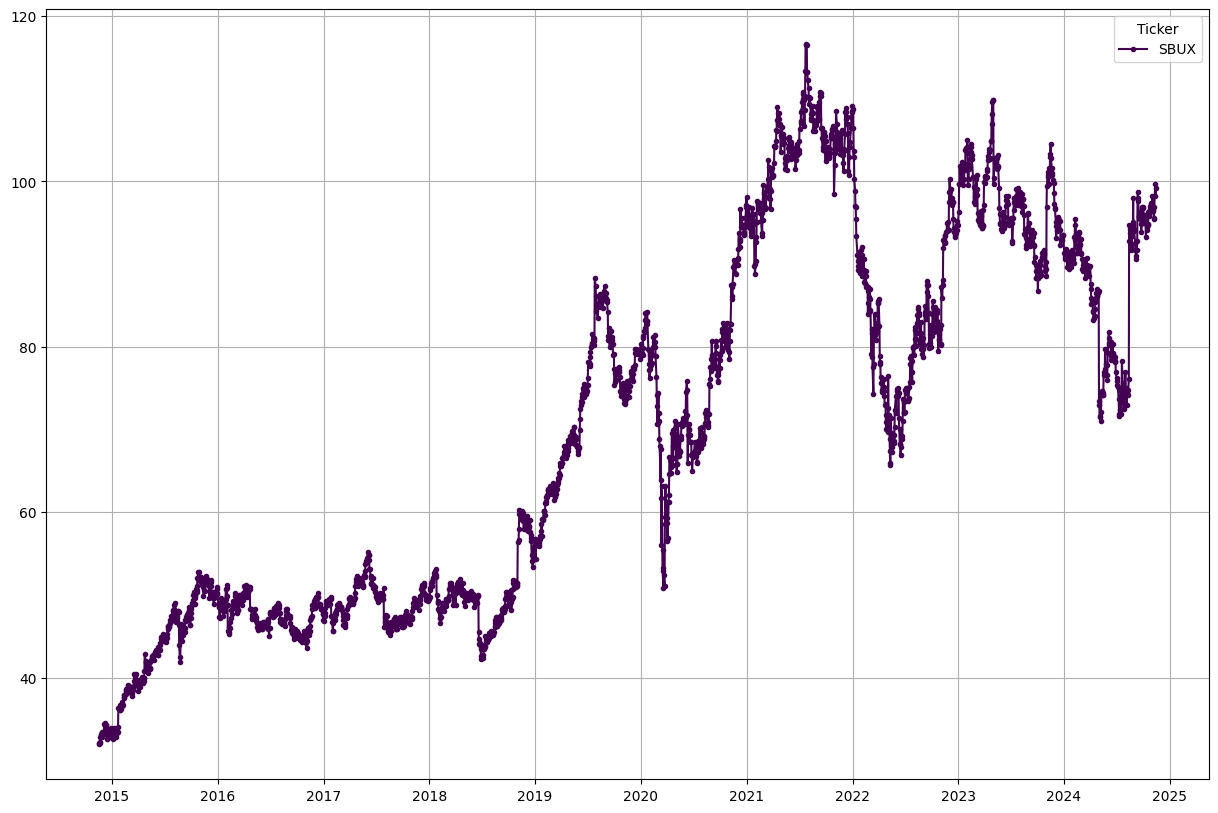

In [ ]:
prices_df = df_values[[ticker_up]]
prices_df.plot(cmap = "viridis",linestyle='-',figsize = (15,10),marker='.')
plt.grid()
plt.show()

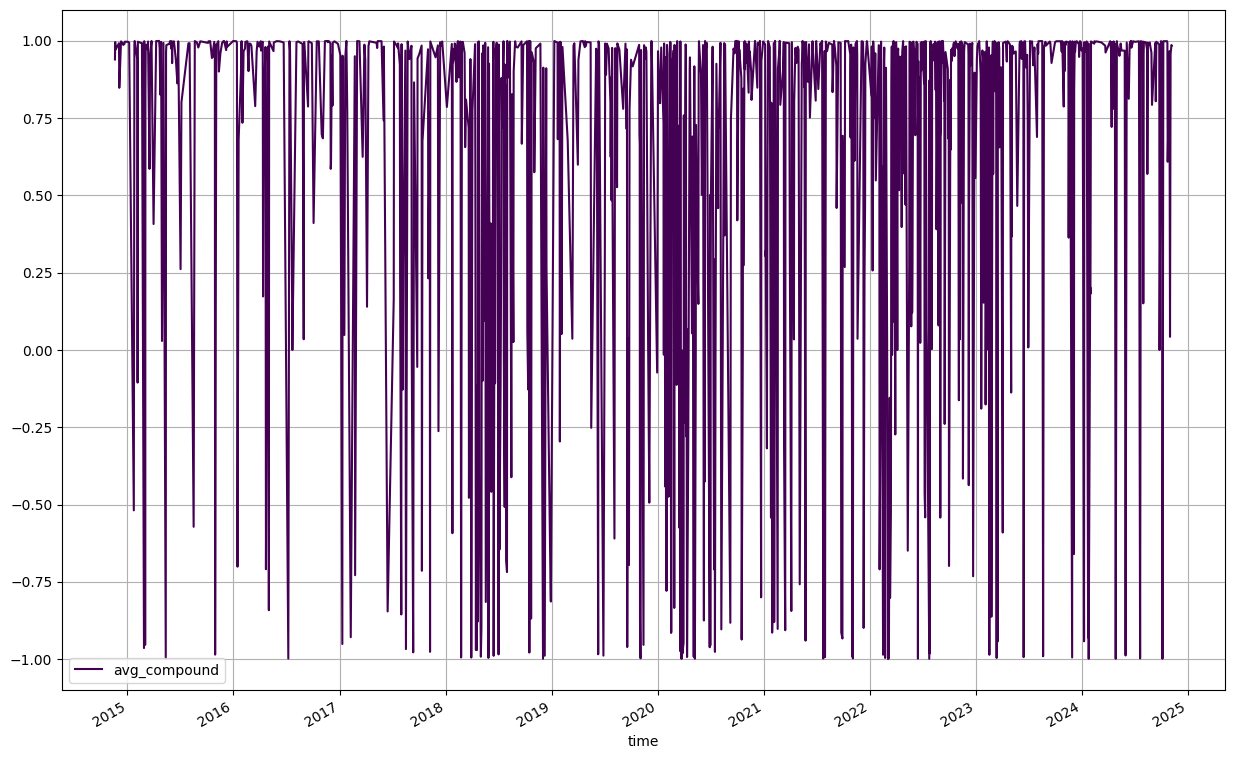

In [ ]:
df_text[["avg_compound"]].plot(cmap = "viridis",linestyle='-',figsize = (15,10))
plt.grid()
plt.show()

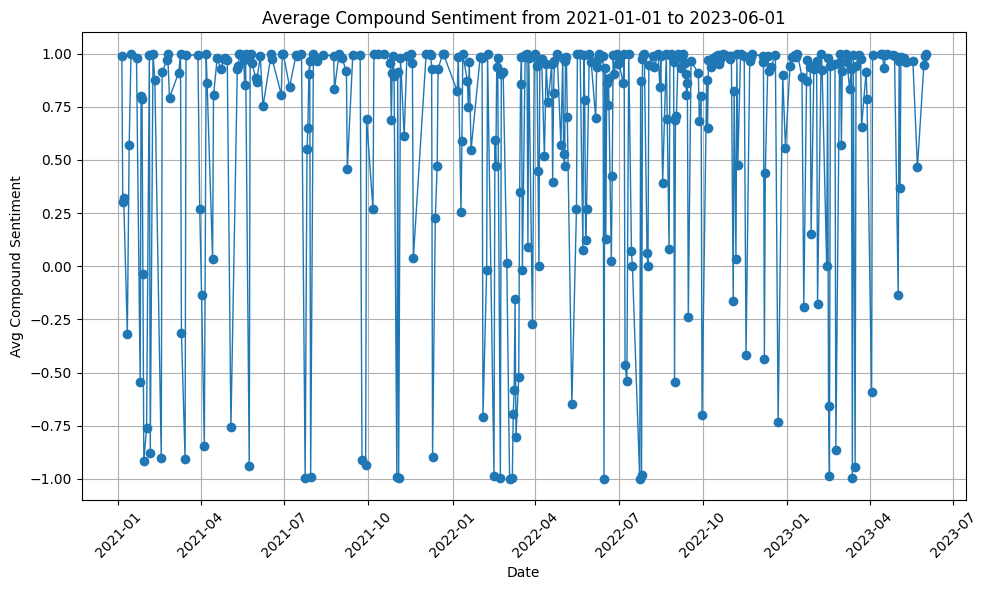

In [ ]:
# Filter the DataFrame for the specified date range
filtered_df = df_text.loc["2021-01-01":"2023-06-01"]

# Plot avg_compound over the specified time range
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['avg_compound'], marker='o', linestyle='-', linewidth=1)
plt.title("Average Compound Sentiment from 2021-01-01 to 2023-06-01")
plt.xlabel("Date")
plt.ylabel("Avg Compound Sentiment")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Resample df_text to weekly frequency, calculating the mean of avg_compound for each week
weekly_sentiment = df_text['avg_compound'].resample('M').mean()

# Convert the result to a DataFrame
weekly_sentiment_df = weekly_sentiment.to_frame(name='weekly_avg_compound')

# Display the weekly sentiment DataFrame
weekly_sentiment_df


<ipython-input-77-9b95bcfb4eff>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_sentiment = df_text['avg_compound'].resample('M').mean()


,weekly_avg_compound
time,
2014-11-30,0.969217
2014-12-31,0.975450
2015-01-31,0.691760
2015-02-28,0.550307
2015-03-31,0.710340
...,...
2024-07-31,0.671020
2024-08-31,0.918250
2024-09-30,0.824721


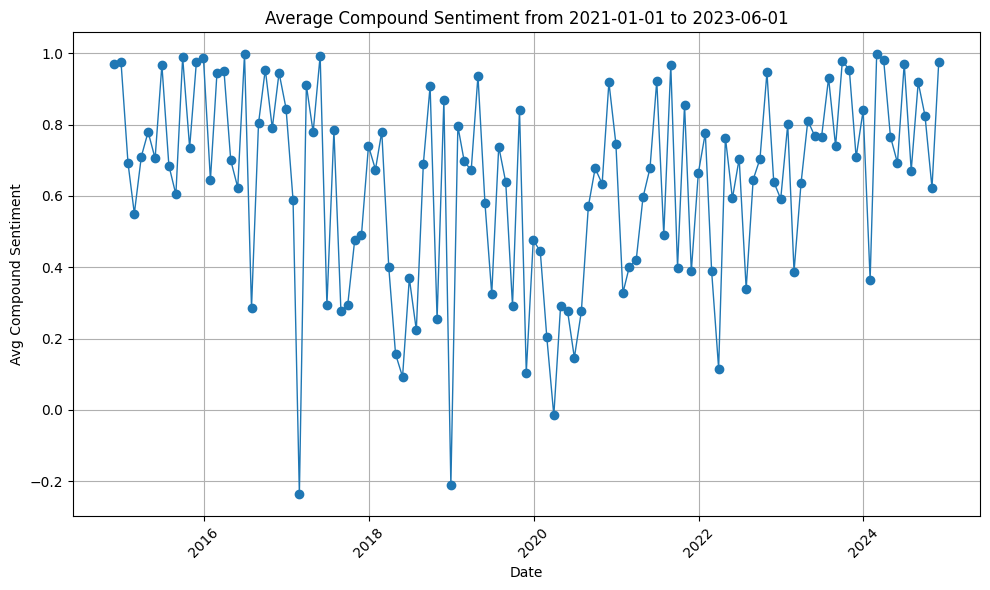

In [ ]:
# Filter the DataFrame for the specified date range
filtered_df = weekly_sentiment_df

# Plot avg_compound over the specified time range
plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['weekly_avg_compound'], marker='o', linestyle='-', linewidth=1)
plt.title("Average Compound Sentiment from 2021-01-01 to 2023-06-01")
plt.xlabel("Date")
plt.ylabel("Avg Compound Sentiment")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-79-82b05c1dbced>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_sentiment = df_text['avg_compound'].resample('M').mean()


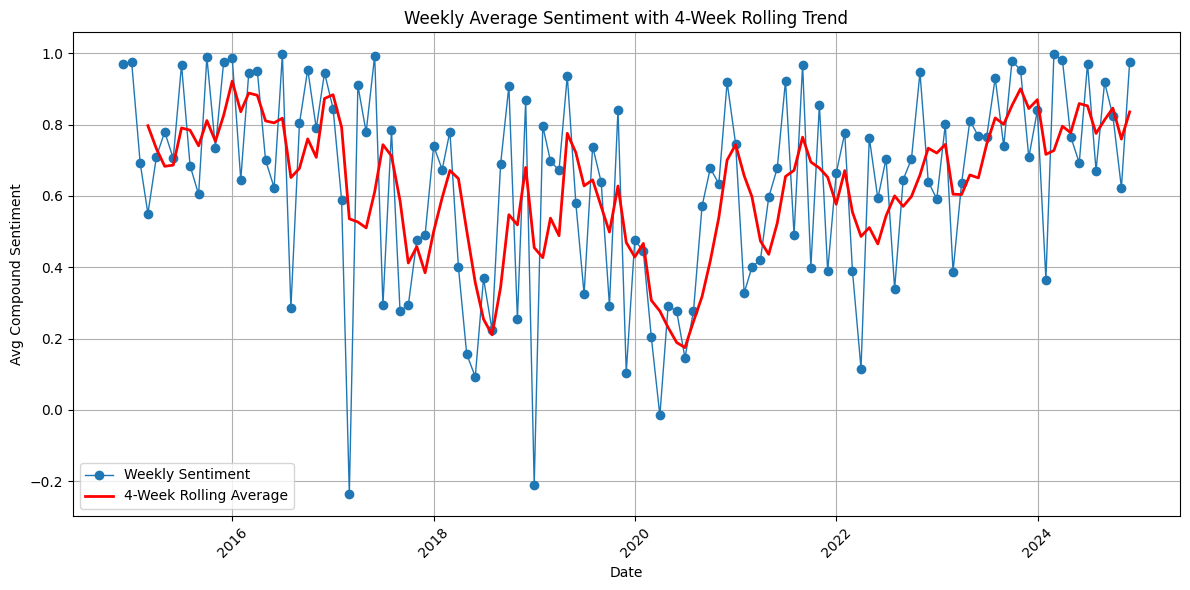

In [ ]:
# Resample df_text to get weekly sentiment averages
weekly_sentiment = df_text['avg_compound'].resample('M').mean()

# Calculate a 4-week rolling average for smoother trend visualization
rolling_avg = weekly_sentiment.rolling(window=4).mean()

# Plot the weekly sentiment along with the 4-week rolling average
plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment.index, weekly_sentiment, label="Weekly Sentiment", marker='o', linestyle='-', linewidth=1)
plt.plot(weekly_sentiment.index, rolling_avg, label="4-Week Rolling Average", color='red', linewidth=2)

# Add titles and labels
plt.title("Weekly Average Sentiment with 4-Week Rolling Trend")
plt.xlabel("Date")
plt.ylabel("Avg Compound Sentiment")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Plotting sentiment against the prices

<ipython-input-80-8568bec2ec08>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices_df["Normalized_Price"] = scaler.fit_transform(prices_df[[ticker_up]])


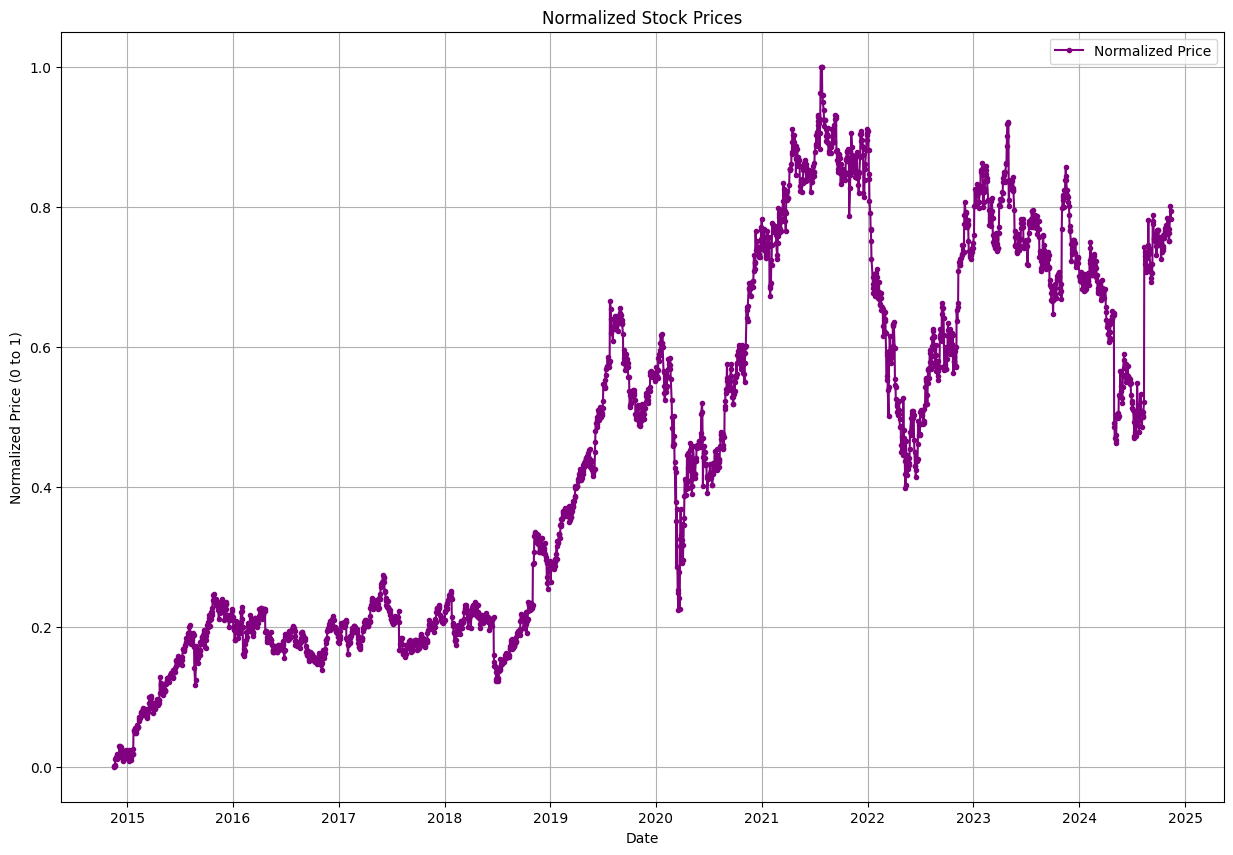

In [ ]:
# First, we need to scale the prices.
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
prices_df["Normalized_Price"] = scaler.fit_transform(prices_df[[ticker_up]])

# Plot the normalized prices
plt.figure(figsize=(15, 10))
plt.plot(prices_df.index, prices_df["Normalized_Price"], linestyle='-', marker='.', color='purple', label="Normalized Price")
plt.title("Normalized Stock Prices")
plt.xlabel("Date")
plt.ylabel("Normalized Price (0 to 1)")
plt.grid(True)
plt.legend()
plt.show()

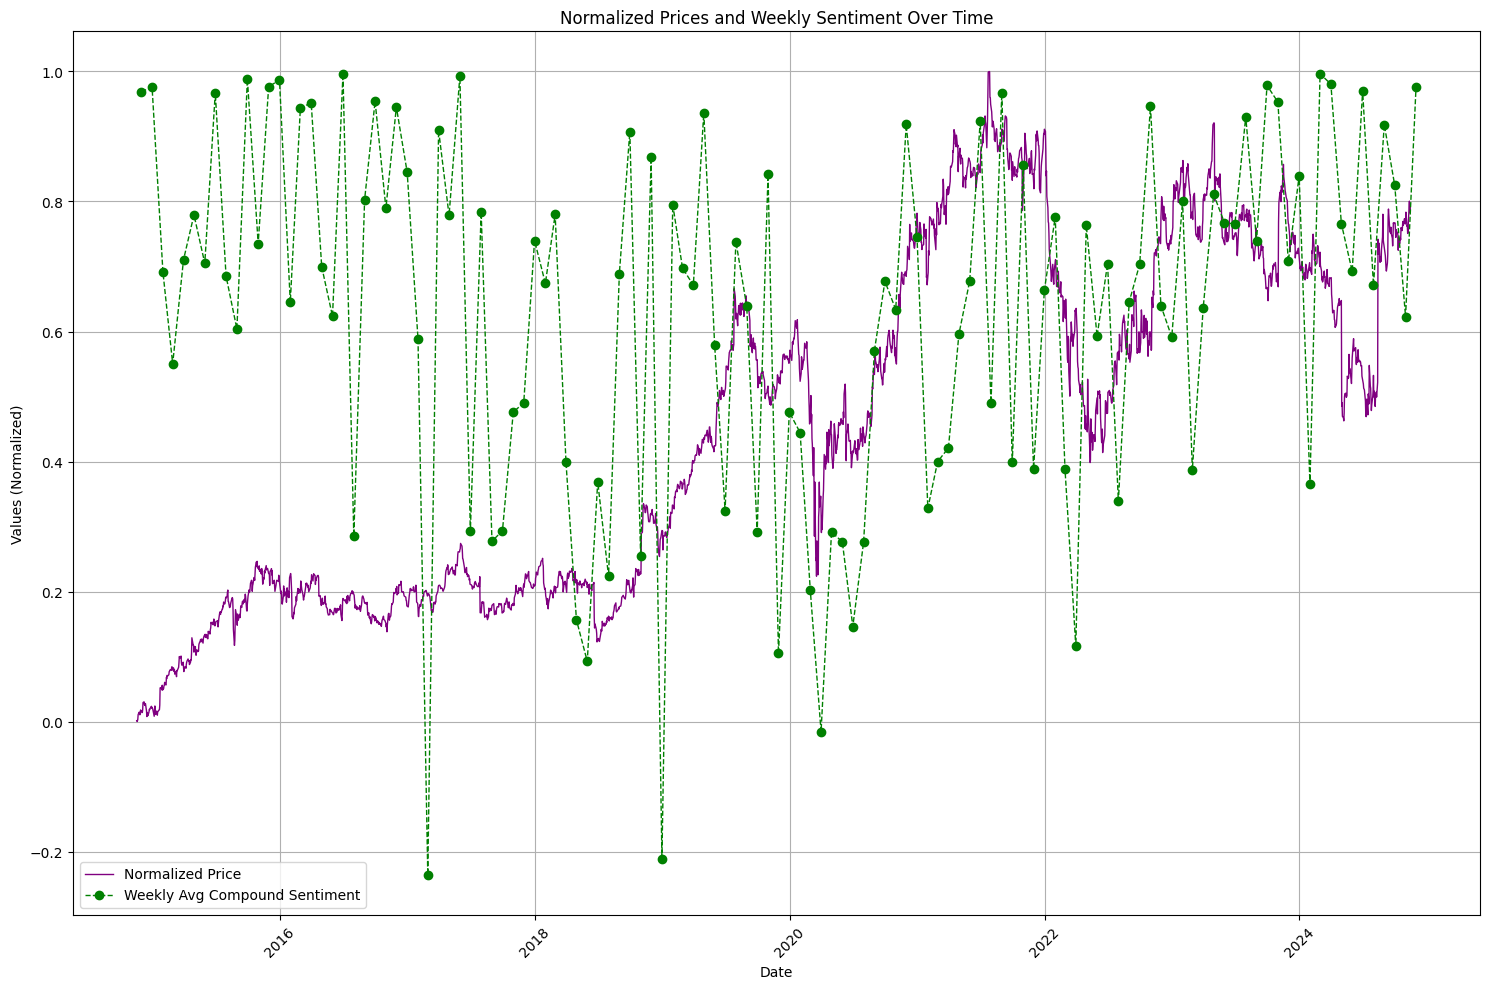

In [ ]:
# Plot both the normalized prices and sentiment values
plt.figure(figsize=(15, 10))

# Plot normalized prices
plt.plot(prices_df.index, prices_df["Normalized_Price"], label="Normalized Price", color='purple', linestyle='-', linewidth=1)

# Plot weekly average compound sentiment
plt.plot(weekly_sentiment_df.index, weekly_sentiment_df["weekly_avg_compound"], label="Weekly Avg Compound Sentiment", color='green', linestyle='--', marker='o', linewidth=1)

# Add title, labels, legend, and grid
plt.title("Normalized Prices and Weekly Sentiment Over Time")
plt.xlabel("Date")
plt.ylabel("Values (Normalized)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


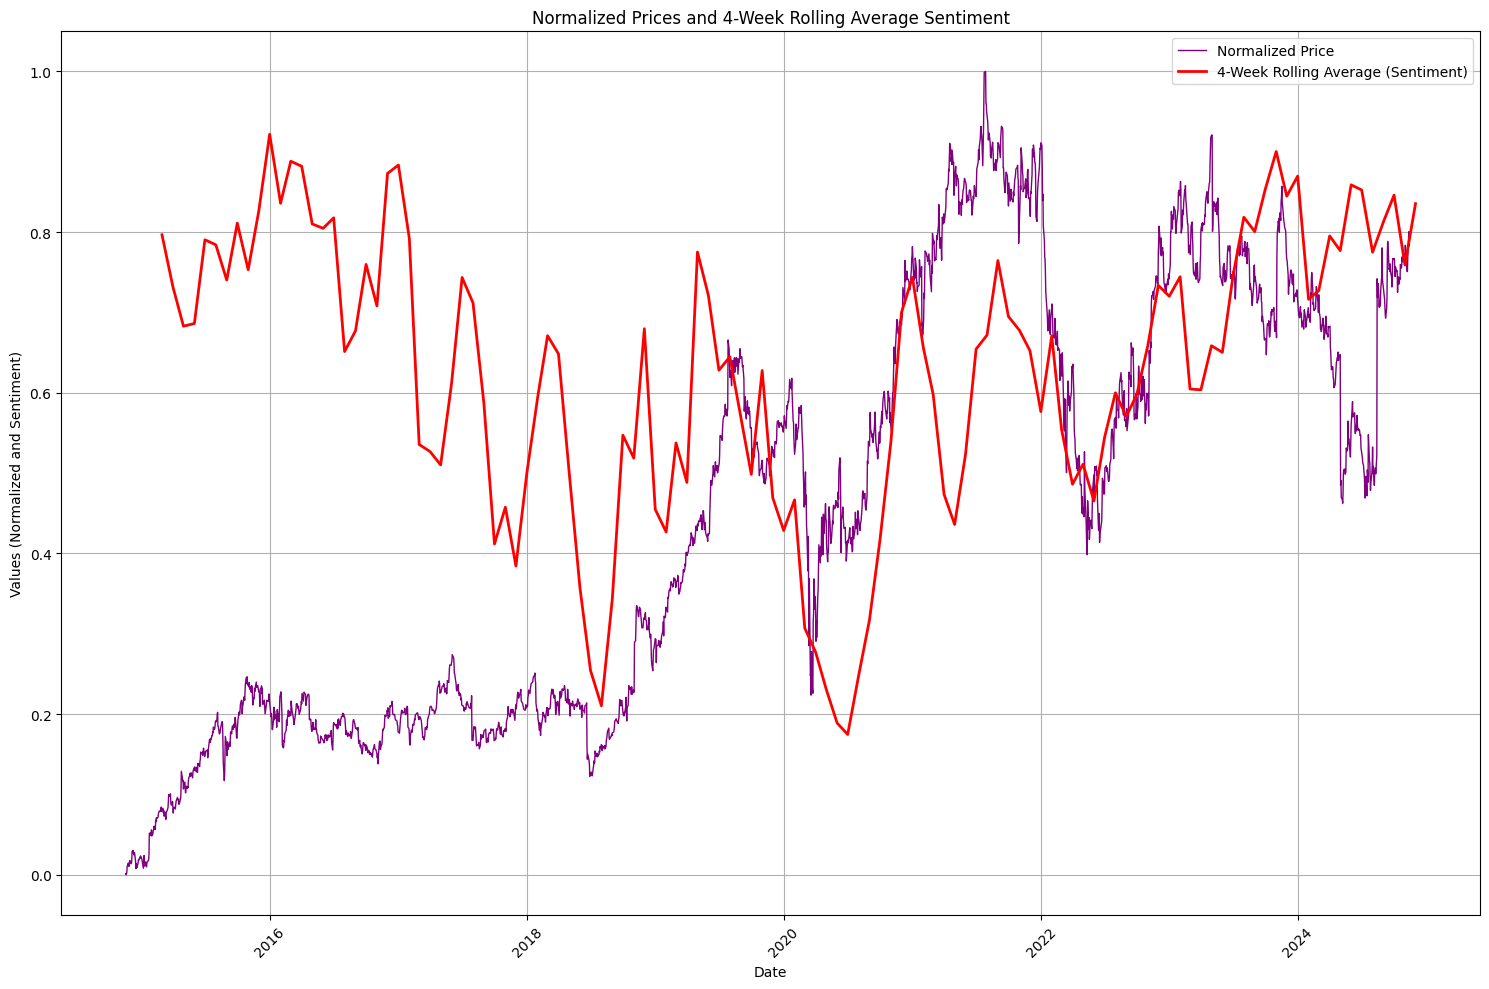

In [ ]:
# Plot normalized prices and 4-week rolling average sentiment
plt.figure(figsize=(15, 10))

# Plot normalized prices
plt.plot(prices_df.index, prices_df["Normalized_Price"], label="Normalized Price", color='purple', linestyle='-', linewidth=1)

# Plot 4-week rolling average of sentiment
rolling_avg = weekly_sentiment.rolling(window=4).mean()
plt.plot(weekly_sentiment.index, rolling_avg, label="4-Week Rolling Average (Sentiment)", color='red', linewidth=2)

# Add titles, labels, legend, and grid
plt.title("Normalized Prices and 4-Week Rolling Average Sentiment")
plt.xlabel("Date")
plt.ylabel("Values (Normalized and Sentiment)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate 16-week rolling averages for normalized prices and sentiment for smoother trends
price_rolling_avg = prices_df["Normalized_Price"].rolling(window=16).mean()
sentiment_rolling_avg = weekly_sentiment.rolling(window=16).mean()

# Plot the 16-week rolling averages
plt.figure(figsize=(15, 10))

# Plot 16-week rolling average of normalized prices
plt.plot(prices_df.index, price_rolling_avg, label="16-Week Rolling Average (Prices)", color='blue', linewidth=2)

# Plot 16-week rolling average of sentiment
plt.plot(weekly_sentiment.index, sentiment_rolling_avg, label="16-Week Rolling Average (Sentiment)", color='red', linewidth=2)

# Add titles, labels, legend, and grid
plt.title("Comparison of 16-Week Rolling Averages: Prices vs Sentiment")
plt.xlabel("Date")
plt.ylabel("16-Week Rolling Average")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Plot normalized prices along with weekly sentiment and 4-week rolling average
plt.figure(figsize=(15, 10))

# Plot normalized prices
plt.plot(prices_df.index, prices_df["Normalized_Price"], label="Normalized Price", color='purple', linestyle='-', linewidth=1)

# Plot weekly sentiment
plt.plot(weekly_sentiment.index, weekly_sentiment, label="Weekly Sentiment", color='green', marker='o', linestyle='-', linewidth=1)

# Plot 4-week rolling average of sentiment
rolling_avg = weekly_sentiment.rolling(window=4).mean()
plt.plot(weekly_sentiment.index, rolling_avg, label="4-Week Rolling Average", color='red', linewidth=2)

# Add titles, labels, legend, and grid
plt.title("Normalized Prices and Weekly Sentiment with 4-Week Rolling Average")
plt.xlabel("Date")
plt.ylabel("Values (Normalized and Sentiment)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 2. Basic stock price prediction using LSTM

## Simple lagging prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf

In [ ]:
# Load the .pkl file
df = pd.read_pickle("historical_prices.pkl")

# Extract the desired column and convert it to a numpy array
df = df[ticker_up].values

# Reshape if necessary (similar to how it was done with the CSV)
df = df.reshape(-1, 1)

# Display the extracted values
print(df.shape)
print(df)


(2515, 1)
[[32.04030609]
 [31.93325615]
 [32.03617859]
 ...
 [99.69335938]
 [98.19264984]
 [99.18650055]]


In [ ]:
# Assume df is already defined and its shape is (2516, 1)

# Create a copy of df
df_all_copy = df.copy()

# Modify df to exclude the last 50 values
df = df[:-50]

# Display the shapes to confirm
print("Shape of df_all_copy:", df_all_copy.shape)
print("Shape of modified df:", df.shape)

Shape of df_all_copy: (2515, 1)
Shape of modified df: (2465, 1)


In [ ]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

When we test or predict using dataset_test (the last 20% + 50 overlap), the model uses the sequences in the test set to predict the next day.
For each prediction, the model takes a 50-day sequence from the test data and predicts the next day (y_test).

In [ ]:
dataset_test.shape

(543, 1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_train[:7]

array([[0.00126466],
       [0.        ],
       [0.0012159 ],
       [0.00306396],
       [0.01065071],
       [0.01434697],
       [0.01283929]])

In [ ]:
dataset_test = scaler.transform(dataset_test)
dataset_test[:7]

array([[0.50663227],
       [0.49124668],
       [0.48968578],
       [0.49146985],
       [0.49459138],
       [0.51042303],
       [0.51722365]])

In [ ]:
def create_my_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

Sliding Window Mechanism:

The model moves a sliding window of 50 days across the test data, which means each prediction is based on the 50 most recent days from the actual data.

In [ ]:
x_train,y_train = create_my_dataset(dataset_train)
x_train[:1]

array([[0.00126466, 0.        , 0.0012159 , 0.00306396, 0.01065071,
        0.01434697, 0.01283929, 0.01035923, 0.01770276, 0.01595195,
        0.01361749, 0.01410389, 0.01818907, 0.0291805 , 0.03029895,
        0.02655406, 0.02475462, 0.02699188, 0.0276241 , 0.0161465 ,
        0.00758686, 0.01395796, 0.01196389, 0.00909459, 0.01444436,
        0.01877271, 0.01799465, 0.02071812, 0.02339291, 0.02052366,
        0.02178803, 0.01882125, 0.01123445, 0.00807326, 0.01755679,
        0.02392794, 0.01079664, 0.01293673, 0.0160492 , 0.01386071,
        0.00977544, 0.01478465, 0.01775143, 0.0180919 , 0.02514368,
        0.05179501, 0.05130866, 0.05237857, 0.04863382, 0.05583166]])

In [ ]:
x_train[:1].shape

(1, 50)

In [ ]:
x_test,y_test = create_my_dataset(dataset_test)
x_test[:1]

array([[0.50663227, 0.49124668, 0.48968578, 0.49146985, 0.49459138,
        0.51042303, 0.51722365, 0.54308922, 0.55111627, 0.5541264 ,
        0.55468395, 0.53138272, 0.51811551, 0.54766016, 0.56672475,
        0.56795108, 0.56940049, 0.55602187, 0.59571185, 0.5913638 ,
        0.57854264, 0.57843115, 0.56862004, 0.58701575, 0.60125549,
        0.61291629, 0.622447  , 0.62513798, 0.61336487, 0.61560762,
        0.59733115, 0.57524265, 0.57232761, 0.58757655, 0.60260116,
        0.56526362, 0.56593645, 0.55797565, 0.56537583, 0.58028841,
        0.55270592, 0.57042123, 0.61291629, 0.62581072, 0.61717709,
        0.62143789, 0.60764655, 0.66213887, 0.65675684, 0.64655356]])

In [ ]:
#x_train.shape
#(957,50,1)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(1922, 50, 1)
(493, 50, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=96,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 185,953 (726.38 KB)

 Trainable params: 185,953 (726.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [ ]:
if (not os.path.exists('stock_prediction.h5')):
    model.fit(x_train,y_train, epochs=50, batch_size=32)
    model.save('stock_prediction.h5')

In [ ]:
model = load_model('stock_prediction.h5')

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
range(1972, 2465)


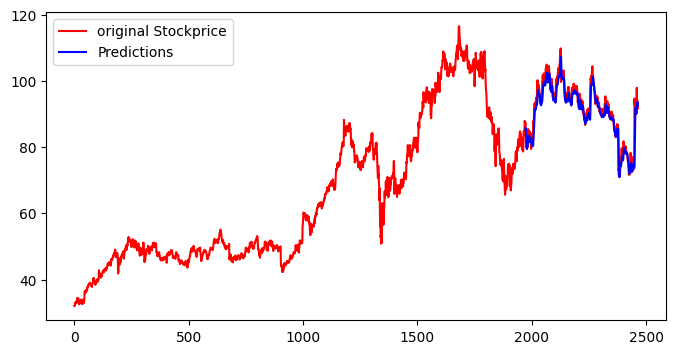

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig,ax = plt.subplots(figsize=(8,4))
plt.plot(df,color='red', label='original Stockprice')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions, color='blue',label='Predictions')
plt.legend()
print(range(len(y_train)+50,len(y_train)+50+len(predictions)))

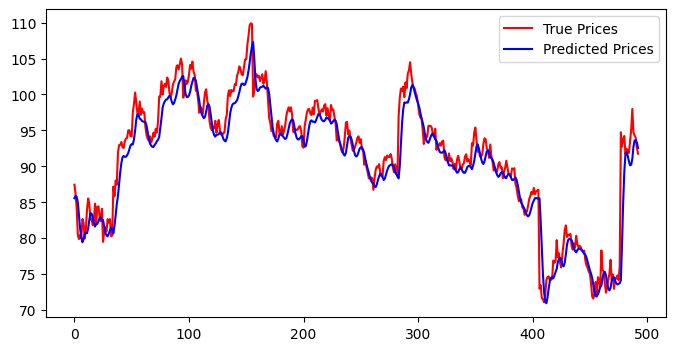

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_test_scaled, color='red',label='True Prices')
plt.plot(predictions,color="blue",label = 'Predicted Prices')
plt.legend()

## Recursive predictions

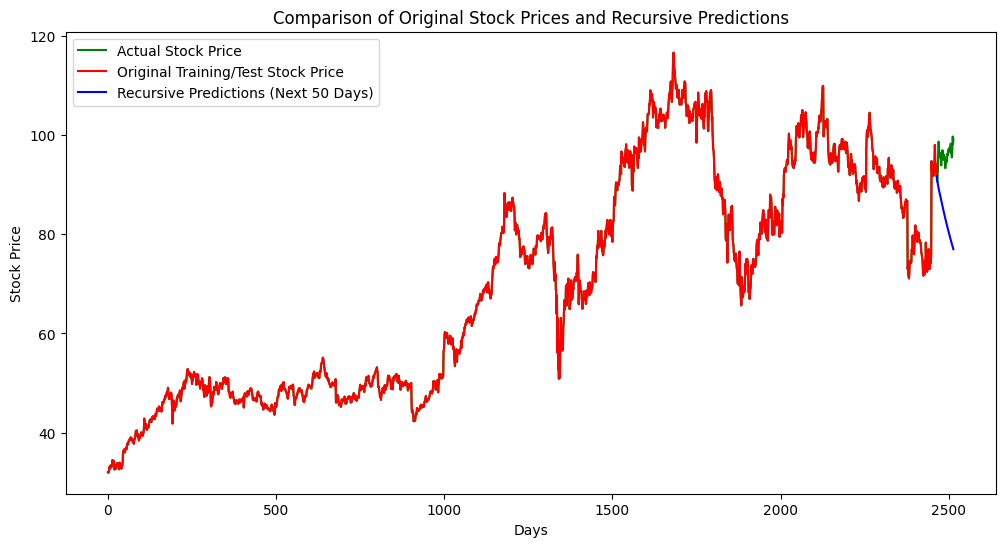

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the pre-trained model and data
model = load_model('stock_prediction.h5')

# Assume df_all_copy is already defined and has a shape of (2516, 1)
# Assume df is defined and has a shape of (2466, 1), without the last 50 values

# Preprocessing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Define a function for recursive prediction for the next 50 days
def recursive_prediction(model, last_sequence, num_days):
    predictions = []
    current_input = last_sequence

    for _ in range(num_days):
        # Reshape to match the model's input shape (1, 50, 1)
        current_input = current_input.reshape(1, current_input.shape[0], 1)
        next_prediction = model.predict(current_input, verbose=0)

        # Store the prediction
        predictions.append(next_prediction[0, 0])

        # Update the input sequence: remove the oldest value and add the prediction
        current_input = np.append(current_input[0, 1:], next_prediction)

    # Reverse the scaling for the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    return predictions

# Use the last 50 days from df as the initial input for predictions
last_50_days = scaled_data[-50:]

# Predict the next 50 days recursively
predicted_future = recursive_prediction(model, last_50_days, 50)

# Plotting the results
plt.figure(figsize=(12, 6))
# Plot the full original data from df_all_copy
plt.plot(range(len(df_all_copy)), df_all_copy, color='green', label='Actual Stock Price')
# Highlight the section used in df (up to the end of training/testing)
plt.plot(range(len(df)), df, color='red', label='Original Training/Test Stock Price')
# Plot the recursive predictions for the next 50 days
plt.plot(range(len(df), len(df) + 50), predicted_future, color='blue', label='Recursive Predictions (Next 50 Days)')

plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Comparison of Original Stock Prices and Recursive Predictions')
plt.legend()
plt.show()


# 3. LSTM Next-Day Prediction

## Loading Sentiment Data

In [ ]:
# Use the sentiment extracted from articles from notebook 2
compound_savefile = ticker + "_sentiment_avg_compound.pkl"

sentiment_data = pd.read_pickle(compound_savefile)
sentiment_data.index = pd.to_datetime(sentiment_data.index)

# Define the full date range based on the span of dates in both datasets
start_date = sentiment_data.index.min()
end_date = sentiment_data.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# If there are no articles from the current day, fill with previous day's value
sentiment_data = sentiment_data.reindex(date_range)
sentiment_data = sentiment_data.fillna(method='ffill')
sentiment_data

<ipython-input-133-6bb3cbbc4adf>:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_data = sentiment_data.fillna(method='ffill')


,compound,avg_compound
2014-11-19,[0.9398],0.93980
2014-11-20,"[0.998, 0.9945]",0.99625
2014-11-21,[0.9716],0.97160
2014-11-22,[0.9716],0.97160
2014-11-23,[0.9716],0.97160
...,...,...
2024-11-01,[0.9578],0.95780
2024-11-02,[0.9578],0.95780
2024-11-03,[0.9578],0.95780
2024-11-04,[0.9866],0.98660


## LSTM Returns Prediction

In [ ]:
# Load the .pkl file
df = pd.read_pickle("historical_prices.pkl")
df = df[[ticker_up]]
df.rename(columns={ticker_up: 'Price'}, inplace=True)


# Merge sentiment_data into df on the index, only keeping dates present in df
df = df.merge(sentiment_data[['avg_compound']], left_index=True, right_index=True, how='left')
df = df[3:] # Because some articles are missing in the first 3 days

df

,Price,avg_compound
2014-11-20,32.192612,0.99625
2014-11-21,32.834808,0.97160
2014-11-24,33.147686,0.97160
2014-11-25,33.020065,0.97160
2014-11-26,32.810135,0.97160
...,...,...
2024-11-07,95.529121,NaN
2024-11-08,96.950333,NaN
2024-11-11,99.693359,NaN
2024-11-12,98.192650,NaN


In [ ]:
import yfinance as yf
import pandas as pd

# Download data
data = yf.download([ticker_up], start="2014-11-01", end="2024-11-16", progress=False)

adj_close = data['Adj Close']
volume = data['Volume']

# df = pd.DataFrame({
#     'Adj Close': adj_close,
#     'Volume': volume
# })

# df
# Remove the time part from the index
volume.index = volume.index.date
adj_close.index = adj_close.index.date

cap = volume * adj_close
cap.rename(columns={ticker_up: "Market Cap"}, inplace=True)

In [ ]:
cap

Ticker,Market Cap
2014-11-03,3.309304e+08
2014-11-04,3.277020e+08
2014-11-05,2.326802e+08
2014-11-06,1.958252e+08
2014-11-07,2.630780e+08
...,...
2024-11-11,1.028168e+09
2024-11-12,8.285889e+08
2024-11-13,8.744579e+08
2024-11-14,6.352607e+08


In [ ]:
# Ensure both DataFrames have datetime indexes
cap.index = pd.to_datetime(cap.index)
df.index = pd.to_datetime(df.index)

# Perform the merge, keeping only indexes from df
df = df.merge(cap, left_index=True, right_index=True, how='left')

df

,Price,avg_compound,Market Cap
2014-11-20,32.192612,0.99625,2.023950e+08
2014-11-21,32.834808,0.97160,4.606004e+08
2014-11-24,33.147686,0.97160,3.124568e+08
2014-11-25,33.020065,0.97160,2.680702e+08
2014-11-26,32.810135,0.97160,2.033177e+08
...,...,...,...
2024-11-07,95.529121,NaN,5.918220e+08
2024-11-08,96.950333,NaN,5.932100e+08
2024-11-11,99.693359,NaN,1.028168e+09
2024-11-12,98.192650,NaN,8.285889e+08


In [ ]:
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Ensure the first `period - 1` values are NaN
    rsi[:period] = np.nan
    return rsi

In [ ]:
# Calculate RSI with a period of 15
RSI_period1 = 15
RSI_period2 = 7
df[f'RSI{RSI_period1}'] = calculate_rsi(df['Price'], period=RSI_period1)
df[f'RSI{RSI_period1}'][:RSI_period1] = 50.0 #set first RSI_period1 values to neutral

df[f'RSI{RSI_period2}'] = calculate_rsi(df['Price'], period=RSI_period2)
df[f'RSI{RSI_period2}'][:RSI_period2] = 50.0 #set first RSI_period2 values to neutral

# Calculate EMA5, EMA10, and EMA20

df['EMA5'] = df['Price'].ewm(span=5, adjust=False).mean()
df['EMA10'] = df['Price'].ewm(span=10, adjust=False).mean()
df['EMA20'] = df['Price'].ewm(span=20, adjust=False).mean()

<ipython-input-140-b43f3c888aad>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[f'RSI{RSI_period1}'][:RSI_period1] = 50.0 #set first RSI_period1 values to neutral
<ipython-input-140-b43f3c888aad>:8: FutureWarning: ChainedAssignmentError

In [ ]:
# Add the 'Next Day' column (shifted version of 'Price')
df['Next Day'] = df['Price'].shift(-1)

# Add the 'Diff' column (difference between 'Price' and 'Next Day')
df['Diff'] = df['Next Day'] - df['Price']

# Add the 'Result' column (0 if 'Diff' < 0, 1 if 'Diff' >= 0)
df['Result'] = np.where(df['Diff'] >= 0, 1, 0)

# Drop the last row as it will have NaN for 'Next Day' and 'Diff'
df = df.dropna()

# Display the DataFrame
df.head()

,Price,avg_compound,Market Cap,RSI15,RSI7,EMA5,EMA10,EMA20,Next Day,Diff,Result
2014-11-20,32.192612,0.99625,2.023950e+08,50.0,50.0,32.192612,32.192612,32.192612,32.834808,0.642197,1
2014-11-21,32.834808,0.97160,4.606004e+08,50.0,50.0,32.406677,32.309375,32.253773,33.147686,0.312878,1
2014-11-24,33.147686,0.97160,3.124568e+08,50.0,50.0,32.653680,32.461795,32.338908,33.020065,-0.127621,0
2014-11-25,33.020065,0.97160,2.680702e+08,50.0,50.0,32.775809,32.563299,32.403780,32.810135,-0.209930,0
2014-11-26,32.810135,0.97160,2.033177e+08,50.0,50.0,32.787251,32.608178,32.442480,33.431744,0.621609,1


## Building the model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)
print(data_set_scaled)

# We are gonna need those for denormalization:
diff_scale = sc.scale_[0]
diff_min = sc.min_[0]

print(diff_scale)
print(diff_min)
print(df['Price'][0])
print(df['Price'][0] * diff_scale + diff_min)
# Xds = X * dfs + dfm
# X = (Xds - dfm) / dfs

[[0.         0.99812481 0.00778999 ... 0.00308727 0.44475467 1.        ]
 [0.00761007 0.98579858 0.02522779 ... 0.00681179 0.43459569 1.        ]
 [0.01131769 0.98579858 0.01522297 ... 0.00529258 0.421007   0.        ]
 ...
 [0.78292878 0.97889789 0.05291851 ... 0.76017064 0.36853168 0.        ]
 [0.7612587  0.99329933 0.0400293  ... 0.7608804  0.4267832  1.        ]
 [0.76196524 0.99239924 0.03549083 ... 0.74893129 0.39397873 0.        ]]
0.011850060284577925
-0.3814843892958891
32.19261169433594
0.0


<ipython-input-142-70abc581bf59>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['Price'][0])
<ipython-input-142-70abc581bf59>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['Price'][0] * diff_scale + diff_min)


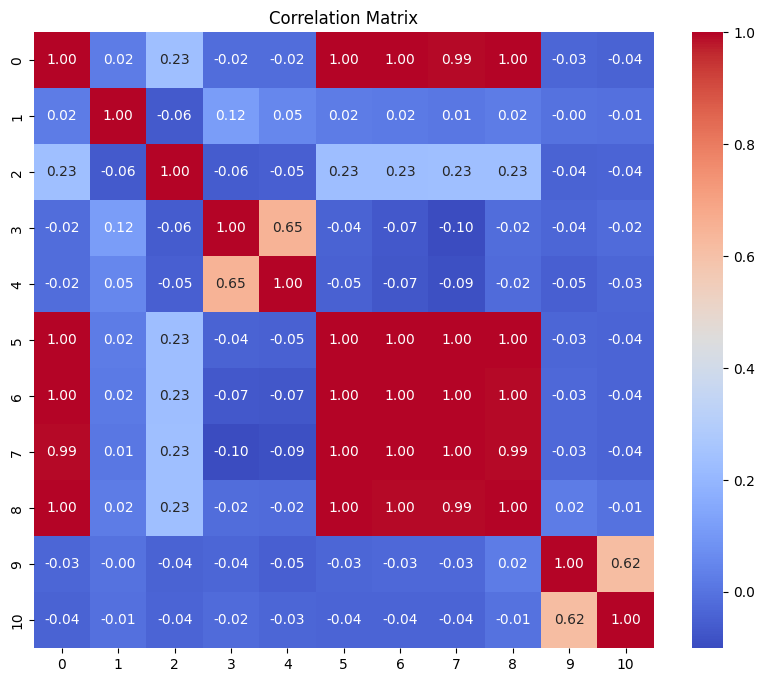

In [ ]:
# Include all column names since the original dataset has 9 columns
raw_data = pd.DataFrame(data_set_scaled)

# Compute the correlation matrix
corr_matrix = raw_data.corr()

# Plot the correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Price, EMA and Next Day are all highly correlated (close to 1.0), hence they seem to provide redundant information.

In [ ]:
# Predicting Price Differences Directly:
# Predicting "diff" values may introduce noise because small errors in prediction accumulate when reconstructed over time.
# A better approach might be predicting the direction (up or down) rather than the exact difference.

# Now, let's provide multiple feature from data to the model

import numpy as np

# Define the number of backcandles (days) to use as features
# This means that the model essentially takes <backcandles> sequential days and predicts the <backcandles + 1th> day
backcandles = 30

# Select the indexes of specific columns you want to include in X
# 0: Price, 1: avg_compound, 2:	RSI15, 3:	RSI7, 4: EMA5, 5:	EMA10, 6:	EMA20, 7:	Next Day, 8:	Diff, 9: Result)
columns_to_include = [1]
amount_of_features = len(columns_to_include)

X = []

for i in range(backcandles, data_set_scaled.shape[0]):
    sample = []
    for j in columns_to_include:
        sample.append(data_set_scaled[i-backcandles:i, j])
    # Transpose sample to ensure the shape is (backcandles, features)
    sample = np.array(sample).T
    X.append(sample)

# Convert X to a NumPy array
X = np.array(X)

# Create the target variable y using the 'Result' column
y = np.array(data_set_scaled[backcandles:, 10])  # 'Result' is at index 10

# Reshape y to match the expected shape
y = np.reshape(y, (len(y), 1))

# Print the shapes for verification
print("X shape:", X.shape)  # Expected shape: (samples, backcandles, features)
print("y shape:", y.shape)  # Expected shape: (samples, 1)
print(X)
print(y)


X shape: (2476, 30, 1)
y shape: (2476, 1)
[[[0.99812481]
  [0.98579858]
  [0.98579858]
  ...
  [0.99864986]
  [0.99864986]
  [0.99854985]]

 [[0.98579858]
  [0.98579858]
  [0.98579858]
  ...
  [0.99864986]
  [0.99854985]
  [0.99854985]]

 [[0.98579858]
  [0.98579858]
  [0.98579858]
  ...
  [0.99854985]
  [0.99854985]
  [0.99729973]]

 ...

 [[0.99859986]
  [0.99432443]
  [0.49994999]
  ...
  [0.98329833]
  [0.52127713]
  [0.52127713]]

 [[0.99432443]
  [0.49994999]
  [0.49994999]
  ...
  [0.52127713]
  [0.52127713]
  [0.97889789]]

 [[0.49994999]
  [0.49994999]
  [0.49994999]
  ...
  [0.52127713]
  [0.97889789]
  [0.99329933]]]
[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [1.]
 [0.]]


In [ ]:
# Split data into train and test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1980
(1980, 30, 1)
(496, 30, 1)
(1980, 1)
(496, 1)
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training set:")
print(dict(zip(unique, counts)))


Class distribution in training set:
{0.0: 936, 1.0: 1044}


In [ ]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU, TimeDistributed
from keras.optimizers import Adam

# Input
lstm_input = Input(shape=(backcandles, amount_of_features), name='lstm_input')

# TimeDistributed Layer
x = TimeDistributed(Dense(64, activation='relu'))(lstm_input)

# First LSTM Layer
x = LSTM(200, return_sequences=True, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second LSTM Layer
x = LSTM(150, return_sequences=True, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Third LSTM Layer
x = LSTM(100, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Layers
x = Dense(50)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output Layer
output = Dense(1, activation='sigmoid', name='output_layer')(x)

# Model
model = Model(inputs=lstm_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history  = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[early_stopping, lr_scheduler])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 278ms/step - accuracy: 0.4953 - loss: 6.8499 - val_accuracy: 0.5000 - val_loss: 5.5618 - learning_rate: 5.0000e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 238ms/step - accuracy: 0.5164 - loss: 5.3931 - val_accuracy: 0.5253 - val_loss: 4.5298 - learning_rate: 5.0000e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.4657 - loss: 4.4593 - val_accuracy: 0.5455 - val_loss: 3.8246 - learning_rate: 5.0000e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.5097 - loss: 3.7580 - val_accuracy: 0.5202 - val_loss: 3.2908 - learning_rate: 5.0000e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.5089 - loss: 3.2492 - val_accuracy: 0.5202 - val_loss: 2.8731 - learning_rate: 5.0000e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 221ms/step - accuracy: 0.5267 - loss: 2.8176 - val_accuracy: 0.5101 - val_loss: 2.5500 - learning_rate: 5.0000e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.49

In [ ]:
# Print available keys in history
print(history.history.keys())
history.history.get('loss', [])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


[6.466432571411133,
 5.156300067901611,
 4.275049209594727,
 3.6273250579833984,
 3.1390671730041504,
 2.74405574798584,
 2.466956377029419,
 2.1903538703918457,
 1.9917420148849487,
 1.815150499343872]

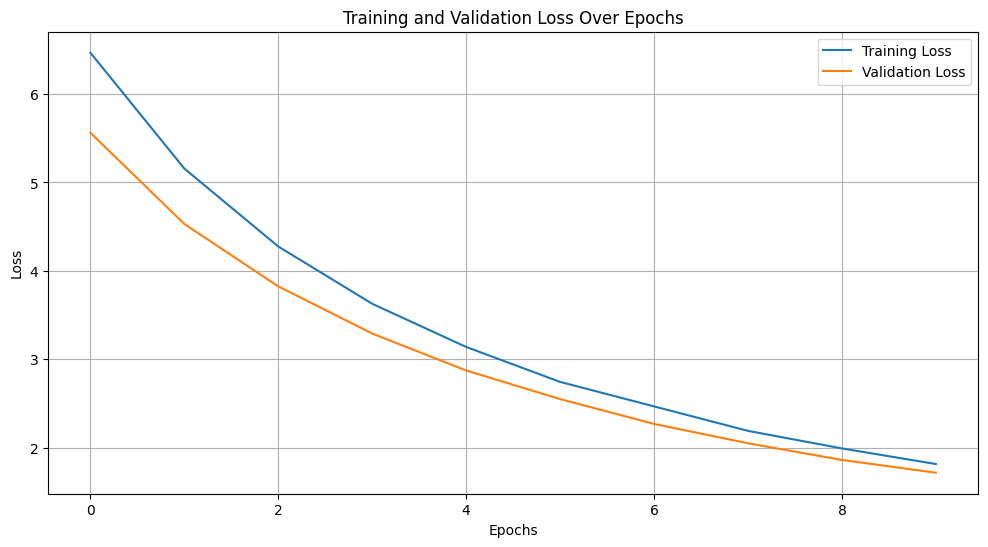

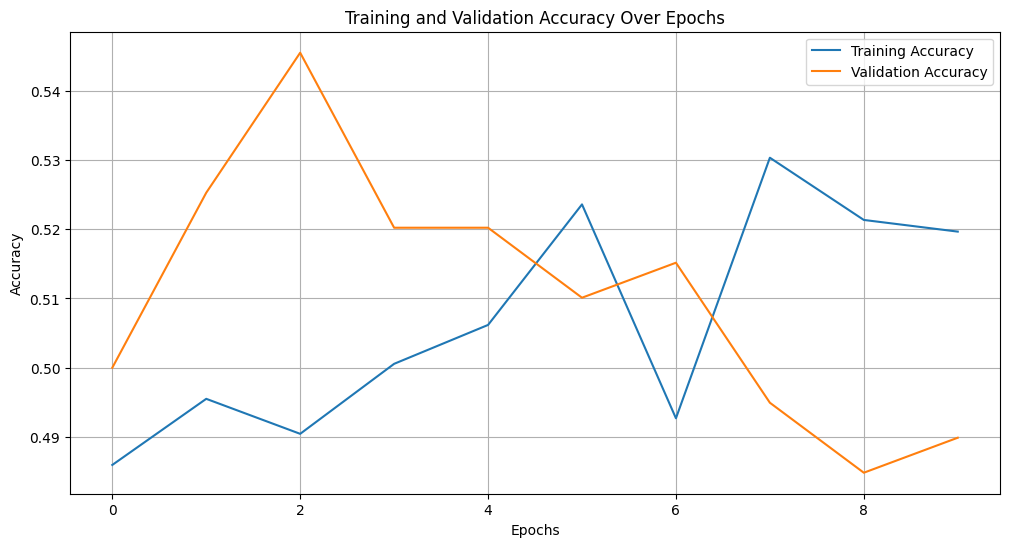

In [ ]:
import matplotlib.pyplot as plt


# Safely access loss and validation loss
training_loss = history.history.get('loss', [])
validation_loss = history.history.get('val_loss', [])

# Safely access accuracy and validation accuracy
training_accuracy = history.history.get('accuracy', [])
validation_accuracy = history.history.get('val_accuracy', [])

# Plot loss
if training_loss and validation_loss:
    plt.figure(figsize=(12, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
if training_accuracy and validation_accuracy:
    plt.figure(figsize=(12, 6))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step


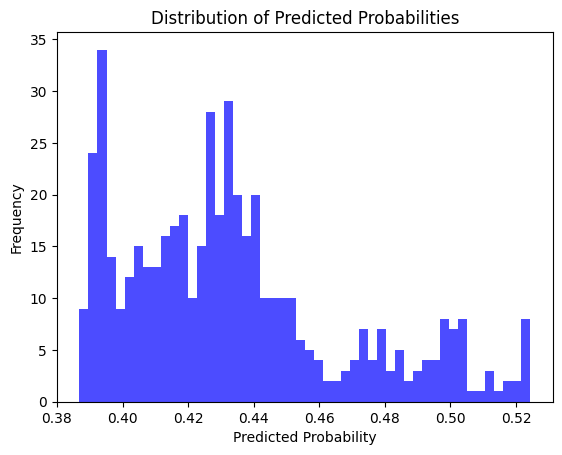

In [ ]:
# Generate predictions on the test set
y_pred_prob = model.predict(X_test)  # Predicted probabilities

import matplotlib.pyplot as plt
plt.hist(y_pred_prob, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Checking median probability
median_threshold = np.median(y_pred_prob)
print(f"Median Threshold: {median_threshold:.3f}")


Median Threshold: 0.428


In [ ]:
# Convert probabilities into binary classes using the median as the threshold
y_pred_binary = (y_pred_prob > median_threshold).astype(int)

# Print the first 10 predictions for verification
for i in range(10):
    print(f"Predicted Probability: {y_pred_prob[i][0]:.3f}, Classified as: {y_pred_binary[i][0]}")

Predicted Probability: 0.432, Classified as: 1
Predicted Probability: 0.438, Classified as: 1
Predicted Probability: 0.432, Classified as: 1
Predicted Probability: 0.431, Classified as: 1
Predicted Probability: 0.434, Classified as: 1
Predicted Probability: 0.436, Classified as: 1
Predicted Probability: 0.436, Classified as: 1
Predicted Probability: 0.433, Classified as: 1
Predicted Probability: 0.427, Classified as: 0
Predicted Probability: 0.420, Classified as: 0


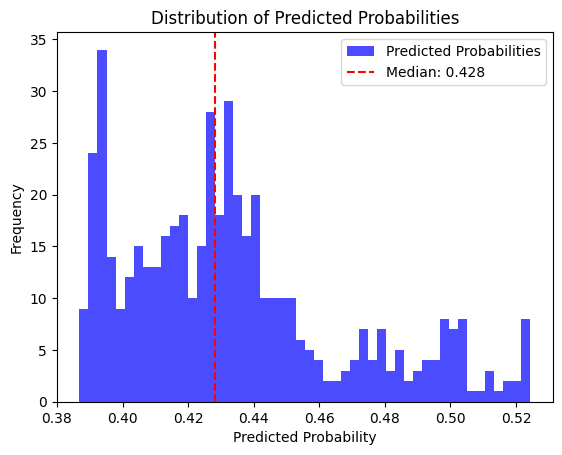

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob, bins=50, color='blue', alpha=0.7, label='Predicted Probabilities')
plt.axvline(median_threshold, color='red', linestyle='--', label=f'Median: {median_threshold:.3f}')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Optional: Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.47      0.47       251
         1.0       0.46      0.47      0.46       245

    accuracy                           0.47       496
   macro avg       0.47      0.47      0.47       496
weighted avg       0.47      0.47      0.47       496

Confusion Matrix:
[[117 134]
 [131 114]]


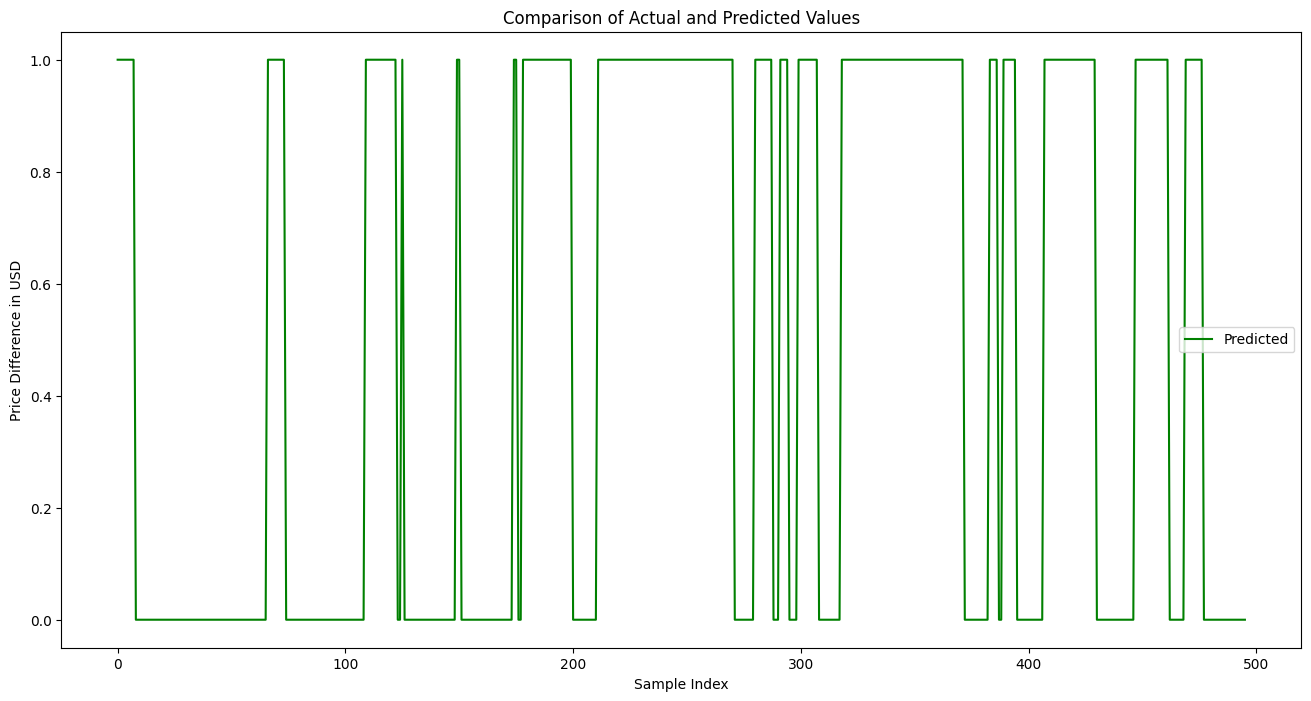

In [ ]:
#
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
# plt.plot(y_test, color='black', label='Actual')  # Actual values in original scale
plt.plot(y_pred_binary, color='green', label='Predicted')  # Predicted values in original scale
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Price Difference in USD')
plt.legend()
plt.show()

In [ ]:
# Calculate the starting index for X_test in the original DataFrame
start_index = splitlimit + backcandles

# Extract the prices corresponding to X_test
test_prices = df['Price'].iloc[start_index:start_index + len(X_test)]

# Check the shape and values
print(test_prices.shape)  # Expected shape: (496,)
print(test_prices)

(496,)
2022-11-15    93.383896
2022-11-16    92.658432
2022-11-17    92.562973
2022-11-18    93.498436
2022-11-21    93.851631
                ...    
2024-10-30    96.721741
2024-10-31    97.099403
2024-11-01    98.262215
2024-11-04    96.433525
2024-11-05    96.493149
Name: Price, Length: 496, dtype: float64


In [ ]:
# Algorithm for calculating profit based on binary predictions

profit = 0.0 # Current cash on hand
holding = False  # Track if we currently "hold" a stock
buy_price = test_prices[0]  # Track the price at which we bought the stock
investment_value = profit  # Total value of cash + stock
investment_points = []

# Loop through each day
for i in range(2, len(y_test) - 2):
    # Actual direction (0 or 1) and predicted direction
    predicted_direction = y_pred_binary[i + 1][0]  # Predicted result (0 for down, 1 for up)

    # Get today's actual price (denormalized) for trading decisions
    actual_today = test_prices[i]

    # SELL: If prediction is 0 (price decrease) and we are holding
    if predicted_direction == 0:
        if holding:
            # Sell the stock and calculate profit
            profit += actual_today
            holding = False  # No longer holding the stock

    # BUY: If prediction is 1 (price increase) and we are not holding
    elif predicted_direction == 1:
        if not holding:
            # Buy the stock and record the buy price
            profit -= actual_today
            holding = True  # Now holding the stock

    # Update investment_value
    if holding:
        investment_value = profit + actual_today  # Cash + current stock value
    else:
        investment_value = profit  # Cash only if not holding

    # Add to investment_points
    investment_points.append([i, investment_value])

# If we're holding a stock at the end, sell it at the last actual price
if holding:
    profit += test_prices[-1]  # Sell the stock
    investment_value = profit  # Final cash value
    investment_points.append([len(y_test) - 1, investment_value])

print(f"Total Profit/Loss: ${profit:.2f}")


Total Profit/Loss: $-27.34


<ipython-input-157-540fc6c5cb88>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_price = test_prices[0]  # Track the price at which we bought the stock
<ipython-input-157-540fc6c5cb88>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_today = test_prices[i]


## Reality check - comparison to the actual stock values

In [ ]:
# But now, let's calculate what was just the stock return:

total_sum = (test_prices[-1] - test_prices[0])
print(f"Actual stock value change: {total_sum:.2f}$")


Actual stock value change: 3.11$


<ipython-input-158-883d40e17793>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_sum = (test_prices[-1] - test_prices[0])


In [ ]:
# So, was our strategy useful or would it be better if we just bought the stock and didn't touch it at all?
# Calculate the difference between strategy profit and buy-and-hold profit
if profit > total_sum:
    print(f"Your strategy outperformed the buy-and-hold approach by ${profit - total_sum:.2f}.")
    print("This suggests that actively trading based on predictions was more effective.")
else:
    print(f"The buy-and-hold approach outperformed your strategy by ${total_sum - profit:.2f}.")
    print("This suggests that simply buying and holding the stock would have been more profitable.")


The buy-and-hold approach outperformed your strategy by $30.45.
This suggests that simply buying and holding the stock would have been more profitable.


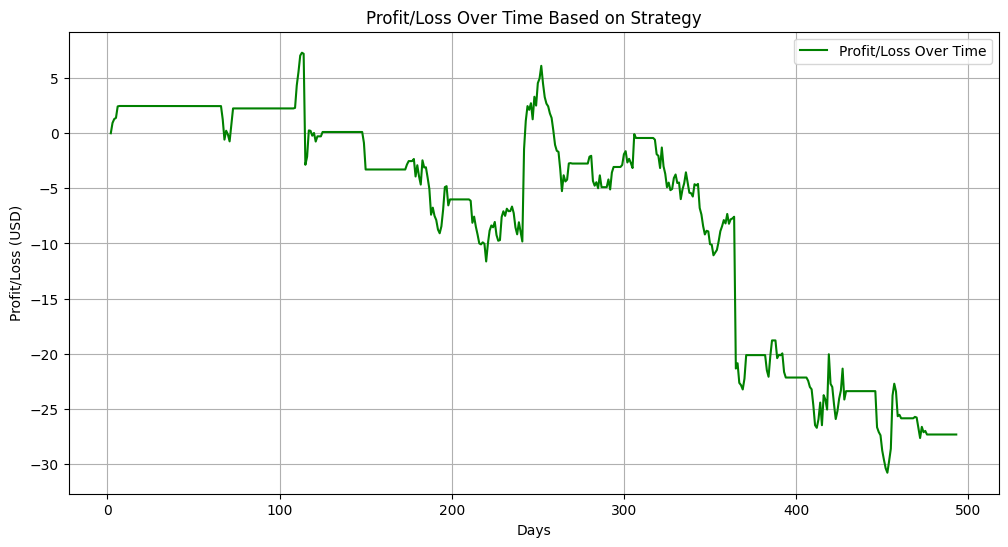

In [ ]:
import matplotlib.pyplot as plt

# Extract the days and corresponding profit values from investment_points
days = [point[0] for point in investment_points]
profits = [point[1] for point in investment_points]

# Plot the investment points
plt.figure(figsize=(12, 6))
plt.plot(days, profits, label='Profit/Loss Over Time', color="green")
plt.title("Profit/Loss Over Time Based on Strategy")
plt.xlabel("Days")
plt.ylabel("Profit/Loss (USD)")
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-161-43a93acc73dc>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_price = test_prices[0]


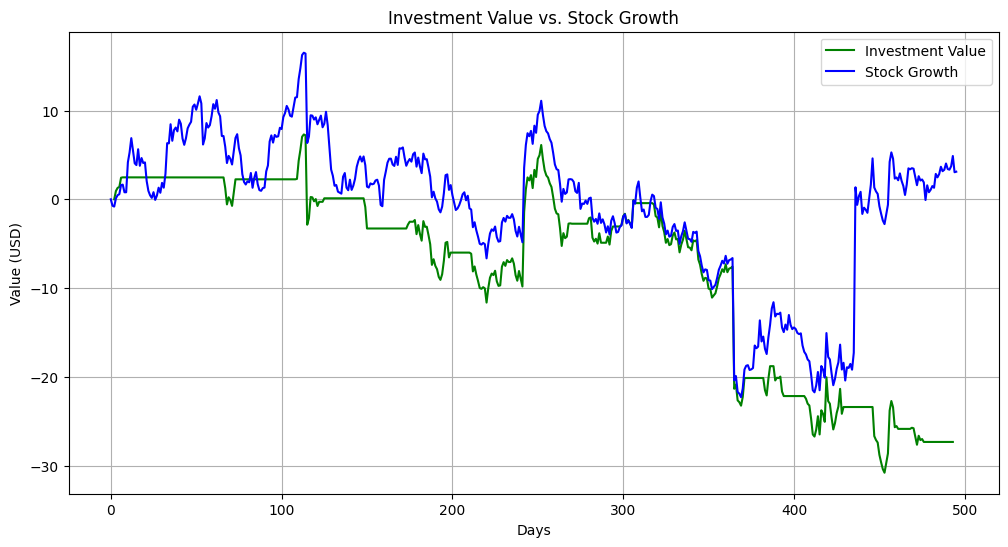

In [ ]:
import matplotlib.pyplot as plt

# Calculate stock growth relative to the initial value
initial_price = test_prices[0]
stock_growth = test_prices - initial_price

# Extract the days and corresponding investment values from investment_points
days = [point[0] for point in investment_points]
investment_values = [point[1] for point in investment_points]

# Plot investment values and stock growth
plt.figure(figsize=(12, 6))

# Plot investment values
plt.plot(days, investment_values, color='green', label='Investment Value')

# Plot stock growth
plt.plot(range(len(stock_growth)), stock_growth, color='blue', label='Stock Growth')

# Add titles and labels
plt.title("Investment Value vs. Stock Growth")
plt.xlabel("Days")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# LSTM Trend Prediction


## Building the model

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

class DataLoader:
    """A class for loading and transforming data for LSTM models"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe[cols].values[:i_split]
        self.data_test = dataframe[cols].values[i_split:]
        self.len_train = len(self.data_train)
        self.len_test = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise=True):
        '''
        Create x, y test data windows.
        '''
        data_windows = [
            self.data_test[i:i+seq_len]
            for i in range(self.len_test - seq_len)
        ]

        data_windows = np.array(data_windows).astype(np.float32)
        if normalise:
            data_windows = self.normalise_windows(data_windows, single_window=False)

        x = data_windows[:, :-1]  # All except the last step
        y = data_windows[:, -1, [0]]  # Target value (last step, first feature)
        return x, y

    def get_train_data(self, seq_len, normalise=True):
        '''
        Create x, y train data windows.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)

        return np.array(data_x, dtype=np.float32), np.array(data_y, dtype=np.float32)

    def generate_train_batch(self, seq_len, batch_size, normalise=True):
        '''Yield a generator of training data.'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1

            yield np.array(x_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i.'''
        window = self.data_train[i:i+seq_len]
        if normalise:
            window = self.normalise_windows(window, single_window=True)[0]

        x = window[:-1]  # All except the last step
        y = window[-1, [0]]  # Target value (last step, first feature)
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero.'''
        # print("window_data length is: " + str(len(window_data)))
        # print(window_data) # It's just 655 (or basically test dataset length) arrays of 49 pairs [points, volume]
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        i = 0
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                base_value = float(window[0, col_i]) if window[0, col_i] != 0 else 1.0
                normalised_col = [(float(p) / base_value) - 1 for p in window[:, col_i]]
                normalised_window.append(normalised_col)

                # if i < 5:
                #   print("base_value is: " + str(base_value))
                #   print("normalised_col is: " + str(normalised_col))

                # i += 1
            normalised_window = np.array(normalised_window).T  # Reshape and transpose array
            normalised_data.append(normalised_window)

        return np.array(normalised_data, dtype=np.float32)


In [ ]:
import datetime as dt

class Timer:
    """A utility class for measuring time durations."""

    def __init__(self):
        self.start_dt = None

    def start(self):
        """Start the timer."""
        self.start_dt = dt.datetime.now()

    def stop(self):
        """Stop the timer and print the elapsed time."""
        if self.start_dt is None:
            print("Timer was not started. Use `start()` to begin timing.")
            return

        end_dt = dt.datetime.now()
        elapsed_time = end_dt - self.start_dt
        print(f'Time taken: {elapsed_time}')
        self.start_dt = None  # Reset timer for reuse


In [ ]:
import os
import numpy as np
import datetime as dt
from numpy import newaxis
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class Model:
    """A class for building and inferencing an LSTM model"""

    def __init__(self):
        self.model = Sequential()

    def load_model(self, filepath):
        print(f'[Model] Loading model from file {filepath}')
        self.model = load_model(filepath)

    def build_model(self, configs):
        timer = Timer()
        timer.start()

        for layer in configs['model']['layers']:
            neurons = layer.get('neurons')
            dropout_rate = layer.get('rate')
            activation = layer.get('activation')
            return_seq = layer.get('return_seq', False)
            input_timesteps = layer.get('input_timesteps')
            input_dim = layer.get('input_dim')

            if layer['type'] == 'dense':
                self.model.add(Dense(neurons, activation=activation))
            elif layer['type'] == 'lstm':
                self.model.add(
                    LSTM(
                        neurons,
                        input_shape=(input_timesteps, input_dim),
                        return_sequences=return_seq,
                    )
                )
            elif layer['type'] == 'dropout':
                self.model.add(Dropout(dropout_rate))

        self.model.compile(
            loss=configs['model']['loss'],
            optimizer=configs['model']['optimizer']
        )

        print('[Model] Model Compiled')
        timer.stop()

    def train(self, x, y, epochs, batch_size, save_dir):
        timer = Timer()
        timer.start()
        print(f'[Model] Training Started')
        print(f'[Model] {epochs} epochs, {batch_size} batch size')

        save_fname = os.path.join(
            save_dir,
            f'{dt.datetime.now().strftime("%d%m%Y-%H%M%S")}-e{epochs}.h5'
        )
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2),
            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
        ]

        self.model.fit(
            x,
            y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks
        )
        self.model.save(save_fname)

        print(f'[Model] Training Completed. Model saved as {save_fname}')
        timer.stop()

    def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
        """Train the model using a data generator."""
        timer = Timer()
        timer.start()
        print(f'[Model] Training Started')
        print(f'[Model] {epochs} epochs, {batch_size} batch size, {steps_per_epoch} batches per epoch')

        # Save filename now uses `.keras` extension
        save_fname = os.path.join(
            save_dir,
            f'{dt.datetime.now().strftime("%d%m%Y-%H%M%S")}-e{epochs}.keras'
        )
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
        ]

        # Use `fit` (TensorFlow 2.x compatible)
        self.model.fit(
            data_gen,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks
        )

        print(f'[Model] Training Completed. Model saved as {save_fname}')
        timer.stop()


    def predict_point_by_point(self, data):
        # Predict each timestep given the last sequence of true data
        print('[Model] Predicting Point-by-Point...')
        predicted = self.model.predict(data)
        predicted = np.reshape(predicted, (predicted.size,))
        return predicted

    def predict_sequences_multiple(self, data, window_size, prediction_len): # data is x_test, shape
        # Predict sequence of steps before shifting prediction run forward
        print('[Model] Predicting Sequences Multiple...')
        prediction_seqs = []
        for i in range(int(len(data) / prediction_len)):
            curr_frame = data[i * prediction_len]
            predicted = []
            for j in range(prediction_len):
                pred = self.model.predict(curr_frame[newaxis, :, :])[0, 0]
                predicted.append(pred)
                curr_frame = curr_frame[1:]
                curr_frame = np.insert(curr_frame, [window_size - 2], pred, axis=0)
            prediction_seqs.append(predicted)
        return prediction_seqs

    def predict_sequence_full(self, data, window_size):
        # Shift the window by 1 new prediction each time, re-run predictions
        print('[Model] Predicting Sequences Full...')
        curr_frame = data[0]
        predicted = []
        for i in range(len(data)):
            pred = self.model.predict(curr_frame[newaxis, :, :])[0, 0]
            predicted.append(pred)
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size - 2], pred, axis=0)
        return predicted


In [ ]:
import os
import json
import math
import matplotlib.pyplot as plt


def plot_results(predicted_data, true_data):
    """Plots predicted vs. true data."""
    fig = plt.figure(facecolor='white', figsize=(12, 6))  # Adjusted figure size
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data', linewidth=2)  # Added thicker line for True Data
    ax.plot(predicted_data, label='Prediction', linewidth=1.5, linestyle='--')  # Dashed line for Prediction
    ax.legend(loc='upper left', fontsize=10, frameon=True)  # Improved legend readability
    ax.set_title("Predicted vs. True Data", fontsize=14)
    ax.set_xlabel("Time Steps", fontsize=12)
    ax.set_ylabel("Normalized Values", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len, title="Predicted vs. True Data", ylabel="Normalized Values", xlabel="Time Steps"):
    """Plots predicted vs. true data for multiple prediction sequences."""
    fig = plt.figure(facecolor='white', figsize=(14, 8))  # Larger figure size
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data', linewidth=2)
    # Pad the list of predictions to align them correctly on the graph
    for i, data in enumerate(predicted_data):
        padding = [None] * (i * prediction_len)
        ax.plot(padding + data, label=f'Prediction {i + 1}', linewidth=1.2)
    ax.legend(loc='upper left', fontsize=10, frameon=True, ncol=2)  # Moved to upper left and split columns
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()  # Ensure no overlapping elements
    plt.show()

In [ ]:
"""Main execution function."""
# Load configuration
with open('config.json', 'r') as config_file:
    configs = json.load(config_file)

# Ensure model save directory exists
save_dir = configs['model']['save_dir']
os.makedirs(save_dir, exist_ok=True)

# Load and preprocess data
data = DataLoader(
    os.path.join('data', ticker + "_" + configs['data']['filename']),
    configs['data']['train_test_split'],
    configs['data']['columns']
)

# Build and train model
model = Model()
model.build_model(configs)

# Test the model and generate predictions
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

prex_test, prey_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=False
)

base_values = []
base50later_values = []
for arr in  prex_test:
  base_values.append([arr[0][0], arr[0][1]])
  base50later_values.append([arr[-1][0], arr[-1][1]])

base_values = np.array(base_values)

first_values = base_values[:, 0]

print(first_values[:5]) # 3994

print(str(len(first_values)))
print(str(len(x_test)))

# first_values
# print(len(sp500_points))
# prex_test.shape # Those are values before normalization. We can take them to plot SP500

[Model] Model Compiled
Time taken: 0:00:00.141432
[101.501785 101.89708  103.24682  101.72353   99.2072  ]
330
330


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


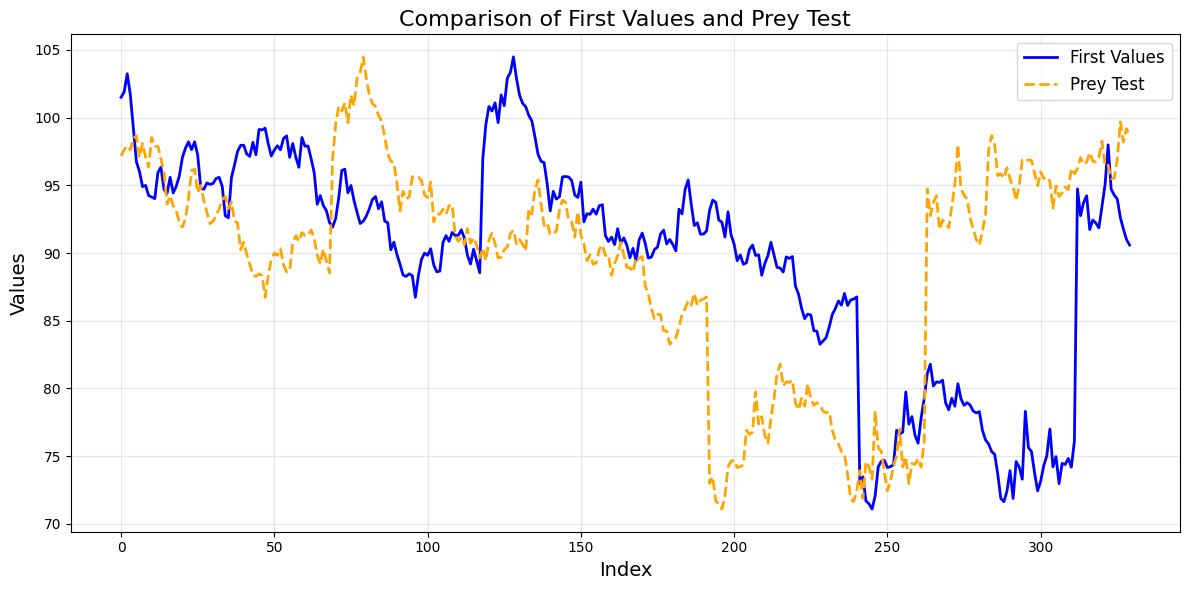

In [ ]:
# Ensure prey_test is flattened for plotting
prey_test = prey_test.flatten()

# Plot both first_values and prey_test
plt.figure(figsize=(12, 6))
plt.plot(first_values, label='First Values', linewidth=2, color='blue')
plt.plot(prey_test, label='Prey Test', linewidth=2, color='orange', linestyle='--')

# Add title and labels
plt.title("Comparison of First Values and Prey Test", fontsize=16)
plt.xlabel("Index", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
print(str(first_values[49]))
print(str(prey_test[0]))

97.16328
97.16328


In [ ]:
# Generative training
steps_per_epoch = math.ceil(
    (data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size']
)
model.train_generator(
    data_gen=data.generate_train_batch(
        seq_len=configs['data']['sequence_length'],
        batch_size=configs['training']['batch_size'],
        normalise=configs['data']['normalise']
    ),
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    steps_per_epoch=steps_per_epoch,
    save_dir=save_dir
)

# Test the model and generate predictions
x_test, y_test = data.get_test_data(
    seq_len=configs['data']['sequence_length'],
    normalise=configs['data']['normalise']
)

# Choose a prediction method
predictions = model.predict_sequences_multiple(
    x_test,
    configs['data']['sequence_length'],
    configs['data']['sequence_length']
)
# predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
# predictions = model.predict_point_by_point(x_test)

[Model] Training Started
[Model] 2 epochs, 32 batch size, 66 batches per epoch
Epoch 1/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 109ms/step - loss: 0.0083
Epoch 2/2
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.0025
[Model] Training Completed. Model saved as saved_models/22112024-103142-e2.keras
Time taken: 0:00:26.418490
[Model] Predicting Sequences Multiple...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38

In [181]:
den_predictions = []
i = 0
for arr in predictions:
  den_arr = []
  j = i # Maybe useful
  for num in arr:
    den_arr.append((num + 1) * first_values[i]) # Try both first_values and prey_test. But remember! We only know first_values, prey_test is unknown
    i += 1

  den_predictions.append(den_arr)

In [182]:
print("Shape of predictions:", np.array(predictions).shape)  # Convert to NumPy array for shape
print("Shape of den_predictions:", np.array(den_predictions).shape)  # Ensure it's a NumPy array
print("Shape of y_test:", y_test.shape)
print("Shape of prey_test:", prey_test.shape)

Shape of predictions: (6, 50)
Shape of den_predictions: (6, 50)
Shape of y_test: (330, 1)
Shape of prey_test: (330,)


## Showcasing predictions

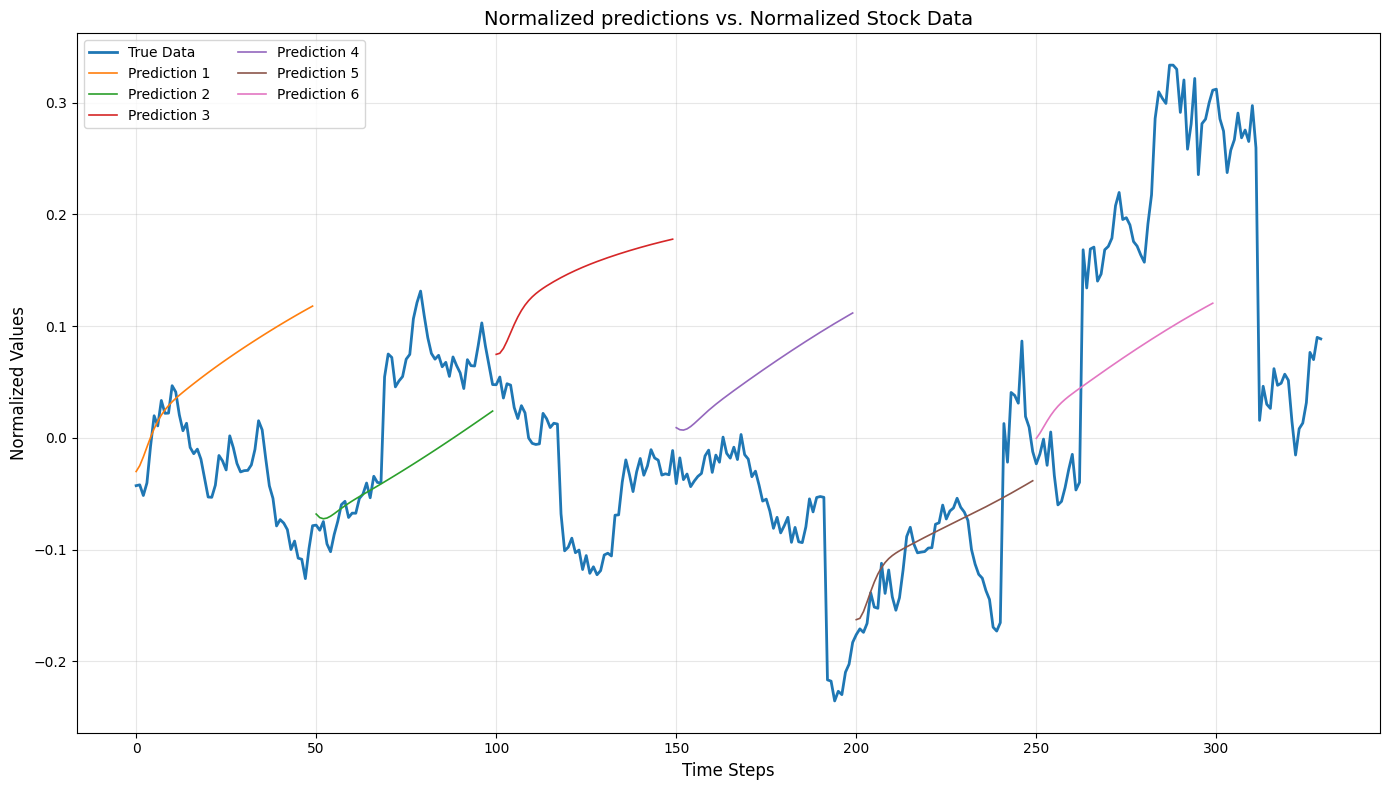

In [183]:
plot_results_multiple(predictions, y_test, configs['data']['sequence_length'], "Normalized predictions vs. Normalized Stock Data")

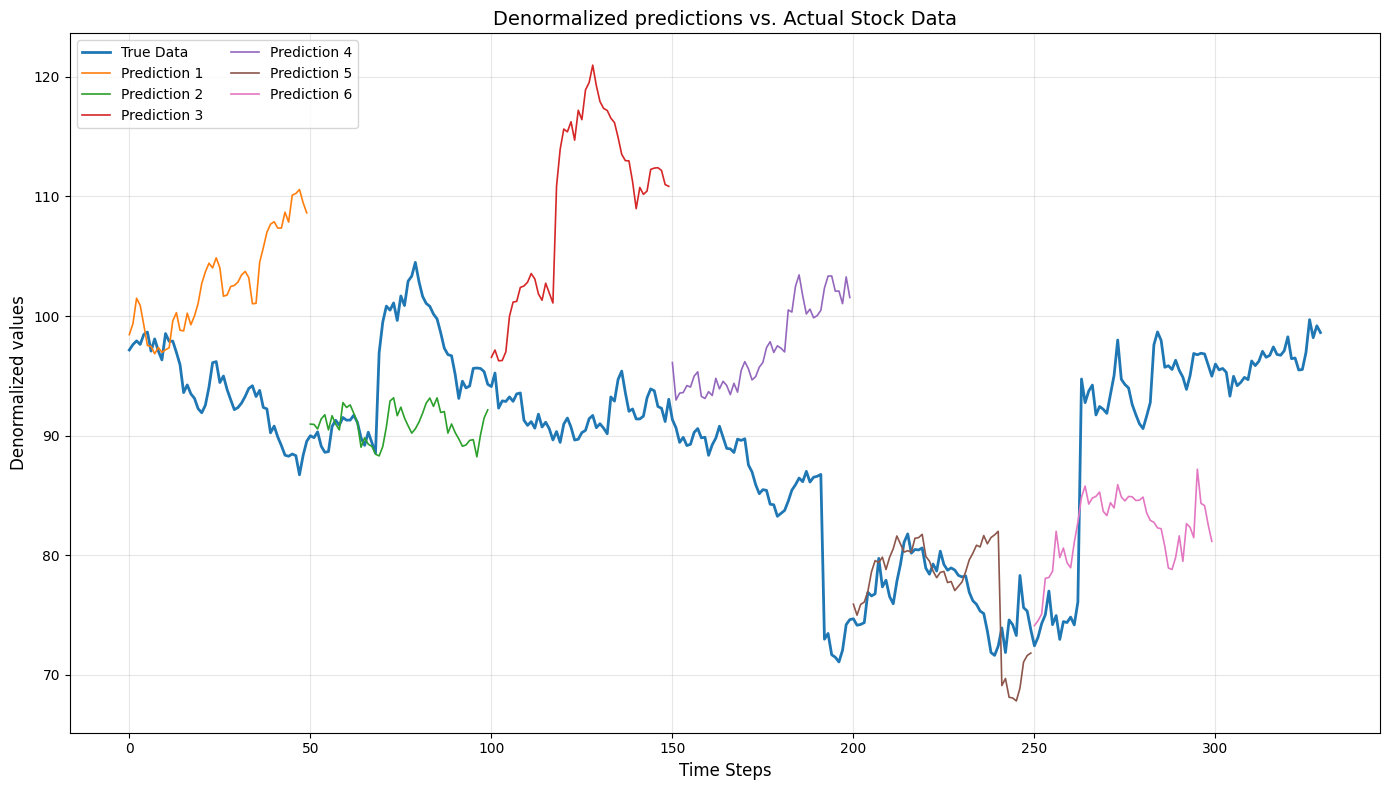

In [184]:
plot_results_multiple(den_predictions, prey_test, configs['data']['sequence_length'], "Denormalized predictions vs. Actual Stock Data", "Denormalized values")

In [185]:
seq_len = np.array(den_predictions).shape[1]
begin = 0

# Initialize counters
tp = 0  # True Positives
tn = 0  # True Negatives
fp = 0  # False Positives
fn = 0  # False Negatives

for pred in den_predictions:
    pred_dir = 0
    real_dir = 0

    # Determine predicted direction
    if pred[0] < pred[seq_len - 1]:
        pred_dir = 1  # Predicted upward trend

    # Determine real direction
    if prey_test[begin] < prey_test[begin + seq_len - 1]:
        real_dir = 1  # Actual upward trend

    # Update counters
    if pred_dir == 1 and real_dir == 1:
        tp += 1  # True Positive
    elif pred_dir == 1 and real_dir == 0:
        fp += 1  # False Positive
    elif pred_dir == 0 and real_dir == 0:
        tn += 1  # True Negative
    elif pred_dir == 0 and real_dir == 1:
        fn += 1  # False Negative

    # Update starting index for the next sequence
    begin += seq_len

# Print results
print("True Positives (TP):", tp)
print("False Positives (FP):", fp)
print("True Negatives (TN):", tn)
print("False Negatives (FN):", fn)
print(seq_len)

True Positives (TP): 2
False Positives (FP): 3
True Negatives (TN): 1
False Negatives (FN): 0
50


## Reality check - comparison to the actual stock values

In [186]:
# Algorithm for calculating profit based on trend predictions
seq_len = np.array(den_predictions).shape[1]
begin = 0

profit = 0.0 # Current cash on hand
holding = False  # Track if we currently "hold" a stock
buy_price = prey_test[0]  # Track the price at which we bought the stock
investment_value = profit  # Total value of cash + stock
investment_points = []

# Loop through each sequence (prediction)
for pred in den_predictions:
    pred_dir = 0 # Predicted direction (0 down, 1 up)
    actual_today = prey_test[begin] # Today's actual price (denormalized)

    # Determine predicted direction
    if pred[0] < pred[seq_len - 1]:
        pred_dir = 1  # Predicted upward trend

    # SELL: If prediction is 0 (price decrease) and we are holding
    if pred_dir == 0:
        if holding:
            # Sell the stock and calculate profit
            profit += actual_today
            holding = False  # No longer holding the stock

    # BUY: If prediction is 1 (price increase) and we are not holding
    elif pred_dir == 1:
        if not holding:
            # Buy the stock and record the buy price
            profit -= actual_today
            holding = True  # Now holding the stock


    # Update investment_values
    if holding:
        investment_value = profit + actual_today  # Cash + current stock value
        investment_points.append([begin, investment_value])
        for i in range(begin + 1, begin + seq_len):
            investment_value = profit + prey_test[i]  # Cash + current stock value
            investment_points.append([i, investment_value])
    else:
        investment_value = profit # No stock, so just cash
        investment_points.append([begin, investment_value])
        for i in range(begin + 1, begin + seq_len):
            investment_value = profit  # Cash only if not holding
            investment_points.append([i, investment_value])

    begin += seq_len

# If we're holding a stock at the end, sell it at the last actual price
if holding:
    profit += prey_test[-1]  # Sell the stock
    investment_value = profit  # Final cash value
    investment_points.append([len(prey_test) - 1, investment_value])


print(f"Stock bought initially for: ${buy_price:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")
print(f"Traded for: {begin} trading days")

final_price = buy_price + profit
years = begin / 252 # Number of trading days in a year
print(f"This equals: {years:.2f} years")

yearly_return = ((final_price / buy_price) ** (1 / years)) - 1
print(f"Average yearly return is: {yearly_return * 100:.2f} %")


Stock bought initially for: $97.16
Total Profit/Loss: $3.72
Traded for: 300 trading days
This equals: 1.19 years
Average yearly return is: 3.20 %


In [187]:
# But now, let's calculate what was just the stock return:
initial_price = prey_test[0]
total_sum = (prey_test[-1] - prey_test[0])
final_stock_price = initial_price + total_sum

print(f"Actual stock value change: {total_sum:.2f}$")

stock_yearly_return = ((final_stock_price / initial_price) ** (1 / years)) - 1
print(f"Average yearly stock return is: {stock_yearly_return * 100:.2f} %")

Actual stock value change: 1.46$
Average yearly stock return is: 1.26 %


In [188]:
# So, was our strategy useful or would it be better if we just bought the stock and didn't touch it at all?
# Calculate the difference between strategy profit and buy-and-hold profit
if profit > total_sum:
    print(f"Your strategy outperformed the buy-and-hold approach by ${profit - total_sum:.2f}.")
    print("This suggests that actively trading based on predictions was more effective.")
else:
    print(f"The buy-and-hold approach outperformed your strategy by ${total_sum - profit:.2f}.")
    print("This suggests that simply buying and holding the stock would have been more profitable.")


Your strategy outperformed the buy-and-hold approach by $2.26.
This suggests that actively trading based on predictions was more effective.


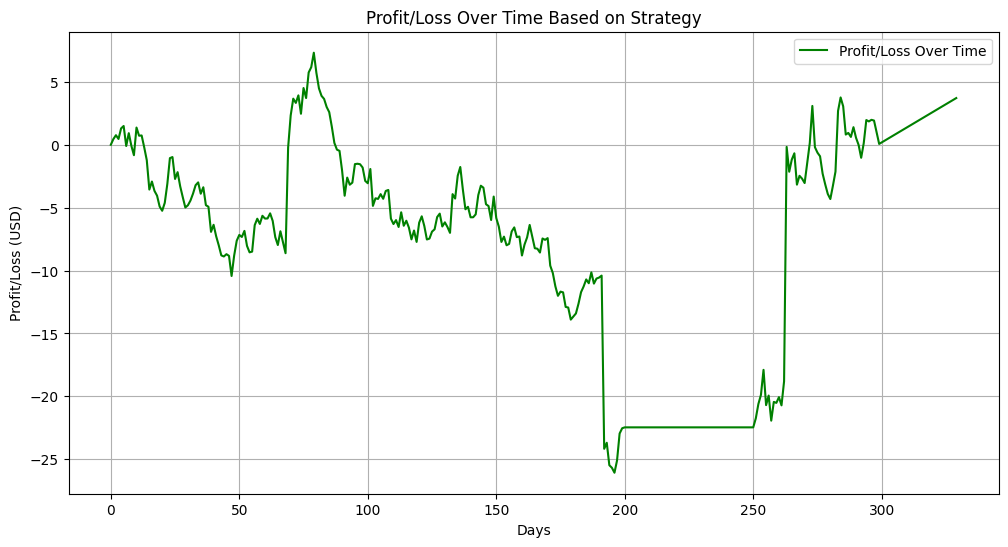

In [189]:
import matplotlib.pyplot as plt

# Extract the days and corresponding profit values from investment_points
days = [point[0] for point in investment_points]
profits = [point[1] for point in investment_points]

# Plot the investment points
plt.figure(figsize=(12, 6))
plt.plot(days, profits, label='Profit/Loss Over Time', color="green")
plt.title("Profit/Loss Over Time Based on Strategy")
plt.xlabel("Days")
plt.ylabel("Profit/Loss (USD)")
plt.grid(True)
plt.legend()
plt.show()


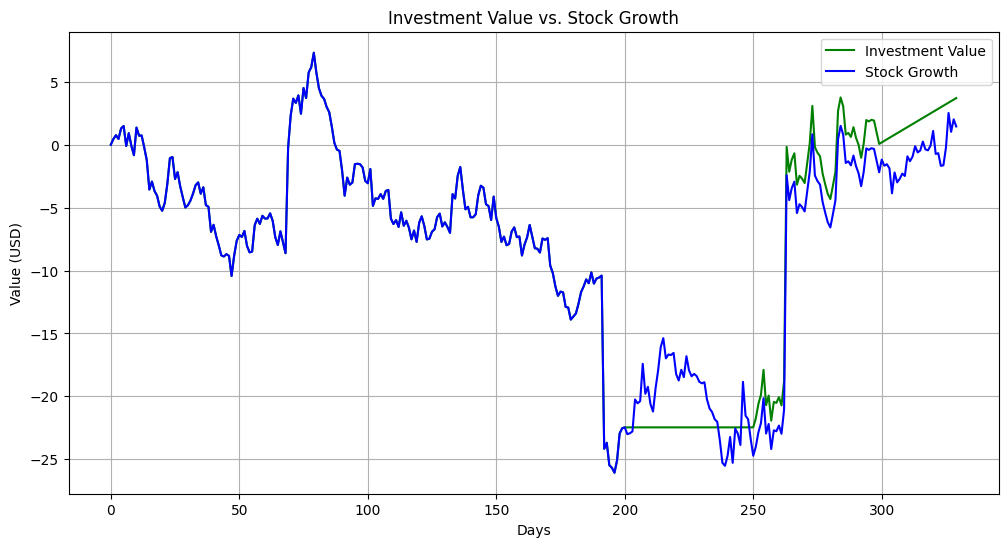

In [190]:
import matplotlib.pyplot as plt

# Calculate stock growth relative to the initial value
initial_price = prey_test[0]
stock_growth = prey_test - initial_price

# Extract the days and corresponding investment values from investment_points
days = [point[0] for point in investment_points]
investment_values = [point[1] for point in investment_points]

# Plot investment values and stock growth
plt.figure(figsize=(12, 6))

# Plot investment values
plt.plot(days, investment_values, color='green', label='Investment Value')

# Plot stock growth
plt.plot(range(len(stock_growth)), stock_growth, color='blue', label='Stock Growth')

# Add titles and labels
plt.title("Investment Value vs. Stock Growth")
plt.xlabel("Days")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
